#Housekeeping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

from typing import Callable, List, Dict
import warnings
warnings.filterwarnings("ignore")
import math
from sklearn.decomposition import PCA

%load_ext google.colab.data_table

Mounted at /content/drive


In [2]:
data_folder = Path(r'/content/drive/MyDrive/All hw colab/MSE723_HW3')

In [3]:
raw_dataset: pd.DataFrame = pd.read_excel(data_folder/'combined_seed_data1.xlsx')
print(raw_dataset.shape)
solvent_reservoir: pd.DataFrame = pd.read_excel(data_folder/'solvents_prop.xlsx')


(552, 90)


# Data Analysis

In [4]:
raw_dataset

sample_id  process_id  exp_id citation_type meta.publication_type  \
0            1           1       1    literature       journal_article   
1            2           2       1    literature       journal_article   
2            3           3       1    literature       journal_article   
3            4           4       1    literature       journal_article   
4            5           5       1    literature       journal_article   
..         ...         ...     ...           ...                   ...   
547        548         499      67    literature       journal_article   
548        549         499      67    literature       journal_article   
549        550         499      67    literature       journal_article   
550        551         499      67    literature       journal_article   
551        552         499      67    literature       journal_article   

                   meta.doi meta.lab_notebook_page lab_sample_id  solution_id  \
0        10.1039/C5TC02579F                    NaN           NaN            1   
1        10.1039/C5TC02579F                    NaN           NaN            1   
2        10.1039/C5TC02579F                    NaN           NaN            1   
3        10.1039/C5TC02579F                    NaN           NaN            1   
4        10.1039/C5TC02579F                    NaN           NaN            1   
..                      ...                    ...           ...          ...   
547  10.1002/adfm.201301007                    NaN           NaN          248   
548  10.1002/adfm.201301007                    NaN           NaN          248   
549  10.1002/adfm.201301007                    NaN           NaN          248   
550  10.1002/adfm.201301007                    NaN           NaN          248   
551  10.1002/adfm.201301007                    NaN           NaN          248   

     polymer_id_1  ... ofet.threshold_voltage_hole  \
0               1  ...                         NaN   
1               1  ...                         NaN   
2               1  ...                         NaN   
3               1  ...                         NaN   
4               1  ...                         NaN   
..            ...  ...                         ...   
547            95  ...                         NaN   
548            95  ...                         NaN   
549            95  ...                         NaN   
550            95  ...                         NaN   
551            95  ...                         NaN   

    ofet.threshold_voltage_electron  ofet.on_off_current  meta.direction  \
0                               NaN                380.0             NaN   
1                               NaN             160000.0             NaN   
2                               NaN             230000.0             NaN   
3                               NaN             610000.0             NaN   
4                               NaN              16000.0             NaN   
..                              ...                  ...             ...   
547                             NaN                  NaN             NaN   
548                             NaN                  NaN             NaN   
549                             NaN                  NaN             NaN   
550                             NaN                  NaN             NaN   
551                             NaN                  NaN             NaN   

     ofet.mobility_regime  ofet.environment ofet.subthreshold_voltage  \
0              saturation               air                       8.3   
1              saturation               air                       2.6   
2              saturation               air                       2.4   
3              saturation               air                       2.2   
4              saturation               air                       3.0   
..                    ...               ...                       ...   
547            saturation               air                       NaN 

## clean naming

In [5]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 90 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   sample_id                              552 non-null    int64  
 1   process_id                             552 non-null    int64  
 2   exp_id                                 552 non-null    int64  
 3   citation_type                          552 non-null    object 
 4   meta.publication_type                  509 non-null    object 
 5   meta.doi                               509 non-null    object 
 6   meta.lab_notebook_page                 48 non-null     object 
 7   lab_sample_id                          48 non-null     object 
 8   solution_id                            552 non-null    int64  
 9   polymer_id_1                           552 non-null    int64  
 10  iupac_name                             552 non-null    object 
 11  common

In [6]:
required_columns = ['common_name', 'mw', 'mn', 'dispersity',
                    'regioregularity','sidechain', 'polymer_wt_pct',
                    'common_name_2','mw.1','dispersity.1','polymer_wt_pct_2','iupac_name.1','iupac_name_2.1','vol_frac_2',
                    'concentration', 'vol_frac','gate_material','dielectric_material','dielectric_thickness',
                    'electrode_material','adhesion_layer','dielectric_material_2', 'dielectric_thickness_2', 'electrode_configuration',
                    'channel_length','channel_width','dielectric_capacitance','deposition_type','params.spin_rate', 'params.spin_time', 'params.environment',
                    'postprocess.annealing.temperature', 'postprocess.annealing.time','coating_process.annealing.environment','film.thickness',
                    'ofet.temperature', 'ofet.hole_mobility','ofet.electron_mobility',  'ofet.environment', 'ofet.on_off_current', 'ofet.threshold_voltage_hole', 'ofet.threshold_voltage_electron'
                    ]

targets  = ['ofet.on_off_current',
            'ofet.hole_mobility',
            'ofet.electron_mobility',
            'ofet.threshold_voltage_hole',
            'ofet.threshold_voltage_electron']



In [7]:
working_data = raw_dataset[required_columns]

### status of nan values

In [8]:
def missing_percent_and_points(df:pd.DataFrame, mssing_threshold:int):
  missing_percentage: pd.Series = df.isnull().sum().sort_values(ascending=False)*100/len(df)
  missing_points: pd.Series = df.isnull().sum().sort_values(ascending=False)  # mask on dataframe for missing points?

  list_param: list[str] = missing_percentage.index.to_list()
  missed_values_percent: list[float] = missing_percentage.to_list()

  missed_points_values: list = missing_points.to_list()

  mis_df = pd.DataFrame({
    "Parameters": list_param,
    "missed_Percentage": missed_values_percent,
    "missing_Points": missed_points_values
     })
  mis_df= mis_df[mis_df['missed_Percentage']<=mssing_threshold]
  mis_df['availability_Percentage'] = 100 - mis_df['missed_Percentage']

  return mis_df

def number_percent_missing_data(df:pd.DataFrame,
                                features_column:str,
                                x_label:str, left_y_label:str,
                                left_data:str,
                                right_y_label:str,
                                right_data:str,
                                title:str):
    fig, ax1 = plt.subplots(figsize=(10, 7.5))

    ax1.bar(df[features_column], df[left_data], color='gray')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(left_y_label)
    ax1.set_title(title)
    ax1.set_xticklabels(df[features_column], rotation=45, ha='right')
    ax1_twin = ax1.twinx()
    # ax1_twin.plot(features, missing_data_points, color='black',line)
    ax1_twin.set_ylabel(right_y_label)
    ax1_twin.set_ylim(0, max(df[right_data])+100)
    plt.tight_layout()
    plt.show()



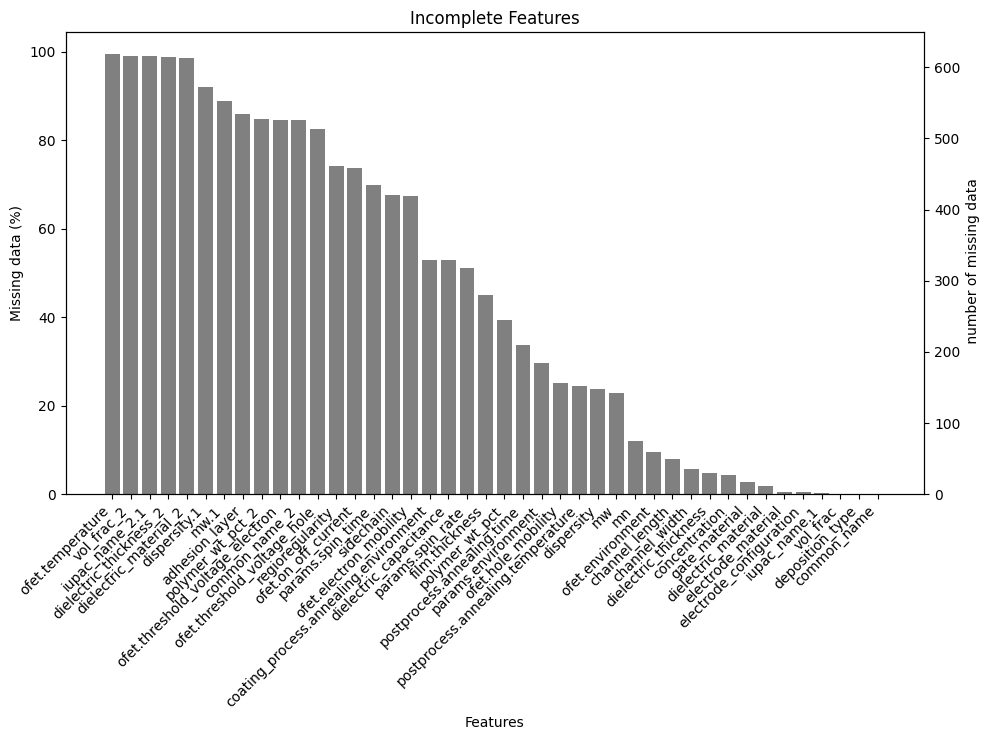

In [9]:
df_miss_under = missing_percent_and_points(working_data, mssing_threshold=100)
number_percent_missing_data(df=df_miss_under,
                            features_column="Parameters",
                            x_label='Features',
                            left_y_label='Missing data (%)',
                            left_data='missed_Percentage',
                            right_y_label=' number of missing data',
                            right_data="missing_Points",
                            title="Incomplete Features")

In [10]:
# Drop columns with more than 30 NaN values
columns_to_keep = ['vol_frac_2', 'iupac_name_2.1']

# Drop columns with over 30% missing values, except specified columns
working_data_dropped_over_30 = working_data.loc[
    :, (working_data.isnull().mean() < 0.3) | working_data.columns.isin(columns_to_keep)
]

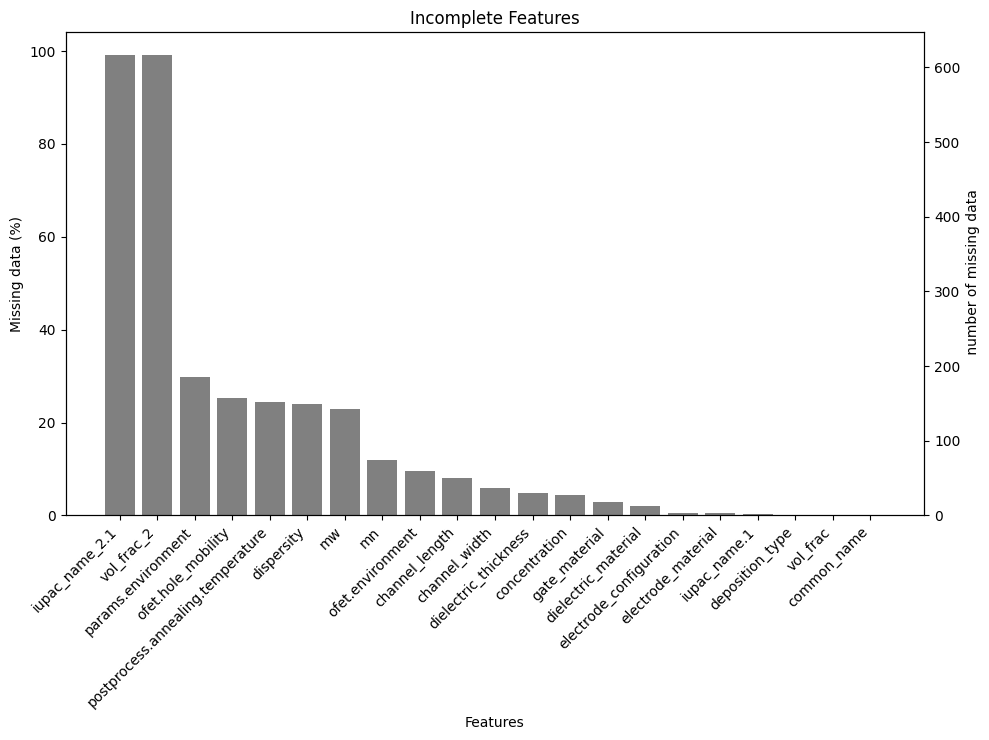

In [11]:
df_miss_under = missing_percent_and_points(working_data_dropped_over_30, mssing_threshold=100)
number_percent_missing_data(df=df_miss_under,
                            features_column="Parameters",
                            x_label='Features',
                            left_y_label='Missing data (%)',
                            left_data='missed_Percentage',
                            right_y_label=' number of missing data',
                            right_data="missing_Points",
                            title="Incomplete Features")

## making decision:



*   Consider hole mobility as target as there is high proportion of missing data in other targets.
*   drop rows with NAN values in target.



In [12]:
final_working_data = working_data_dropped_over_30.dropna(subset=['ofet.hole_mobility']).reset_index(drop=True)


In [13]:
final_working_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   common_name                        413 non-null    object 
 1   mw                                 339 non-null    float64
 2   mn                                 399 non-null    float64
 3   dispersity                         333 non-null    float64
 4   iupac_name.1                       411 non-null    object 
 5   iupac_name_2.1                     4 non-null      object 
 6   vol_frac_2                         4 non-null      float64
 7   concentration                      397 non-null    float64
 8   vol_frac                           413 non-null    float64
 9   gate_material                      402 non-null    object 
 10  dielectric_material                402 non-null    object 
 11  dielectric_thickness               394 non-null    float64

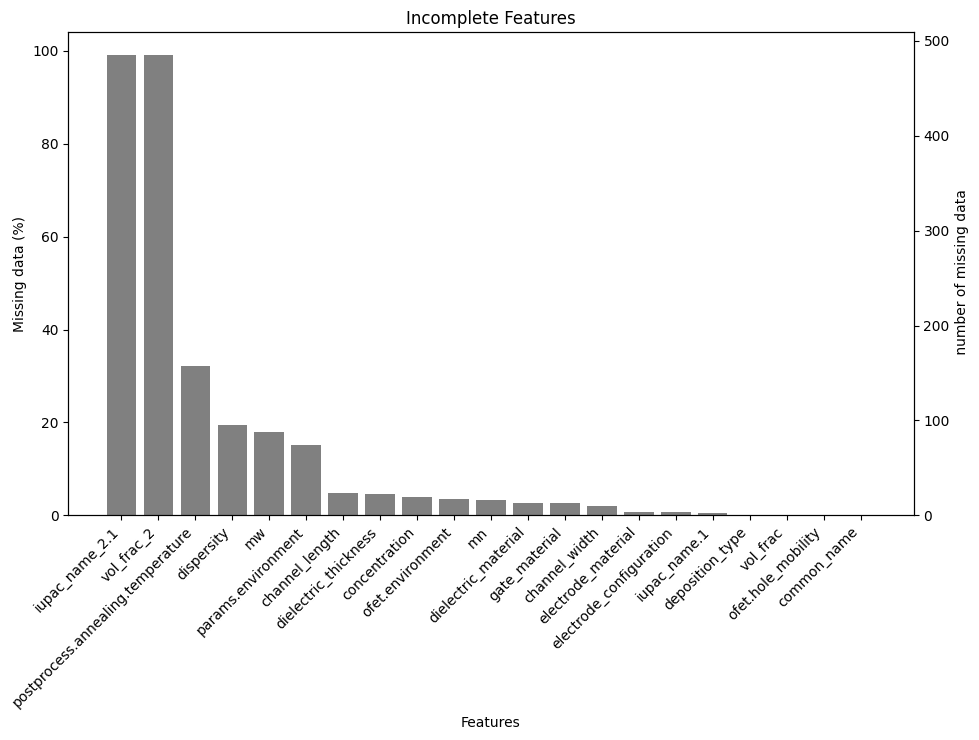

In [14]:
df_miss_under_hole_filtered = missing_percent_and_points(final_working_data, mssing_threshold=100)
number_percent_missing_data(df=df_miss_under_hole_filtered,
                            features_column="Parameters",
                            x_label='Features',
                            left_y_label='Missing data (%)',
                            left_data='missed_Percentage',
                            right_y_label=' number of missing data',
                            right_data="missing_Points",
                            title="Incomplete Features")

## distribution of data before imputation

In [15]:
numerical_params = [
    'mw',
    'mn',
    'dispersity',
    'concentration',
    'dielectric_thickness',
    'channel_length',
    'channel_width',
    'postprocess.annealing.temperature',
    'ofet.hole_mobility'
]

In [16]:
def distribution_plot(df: pd.DataFrame, parameters: List[str], log_cutoff: int = 200, columns_per_row: int = 2,
                      figsize=(16, 10.5), title: str = "Distribution Plots"
                      ):
    num_plots = len(parameters)
    num_rows = (num_plots - 1) // columns_per_row + 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=figsize)
    fig.suptitle(title, fontsize=20, fontweight='bold')
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for i, column in enumerate(parameters):
        row_idx = i // columns_per_row
        col_idx = i % columns_per_row

        # Determine the main plot
        data_range = df[column].max() - df[column].min()
        if data_range >= log_cutoff:
            data = np.log10(df[column])
            xlabel = f'log {column}'
        else:
            data = df[column]
            xlabel = column

        # Histogram plot
        sns.histplot(data, ax=axes[row_idx, col_idx], kde=True, color='#259AC1')

        axes[row_idx, col_idx].set_xlabel(xlabel, fontsize=17, fontweight='bold')
        axes[row_idx, col_idx].set_ylabel('Occurrence ', fontsize=17, fontweight='bold')

        # Box plot as inset
        box_inset = axes[row_idx, col_idx].inset_axes([0.01, -0.5, 0.99, 0.2])  # Adjust position for the inset box plot
        sns.boxplot(x=data, ax=box_inset, color='#259AC1')
        box_inset.set(yticks=[], xlabel=None)  # Remove y-ticks and x-label from the box plot
        box_inset.tick_params(axis='x', labelsize=10)

    # Remove any unused subplots
    for j in range(i + 1, num_rows * columns_per_row):
        row_idx = j // columns_per_row
        col_idx = j % columns_per_row
        fig.delaxes(axes[row_idx, col_idx])

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


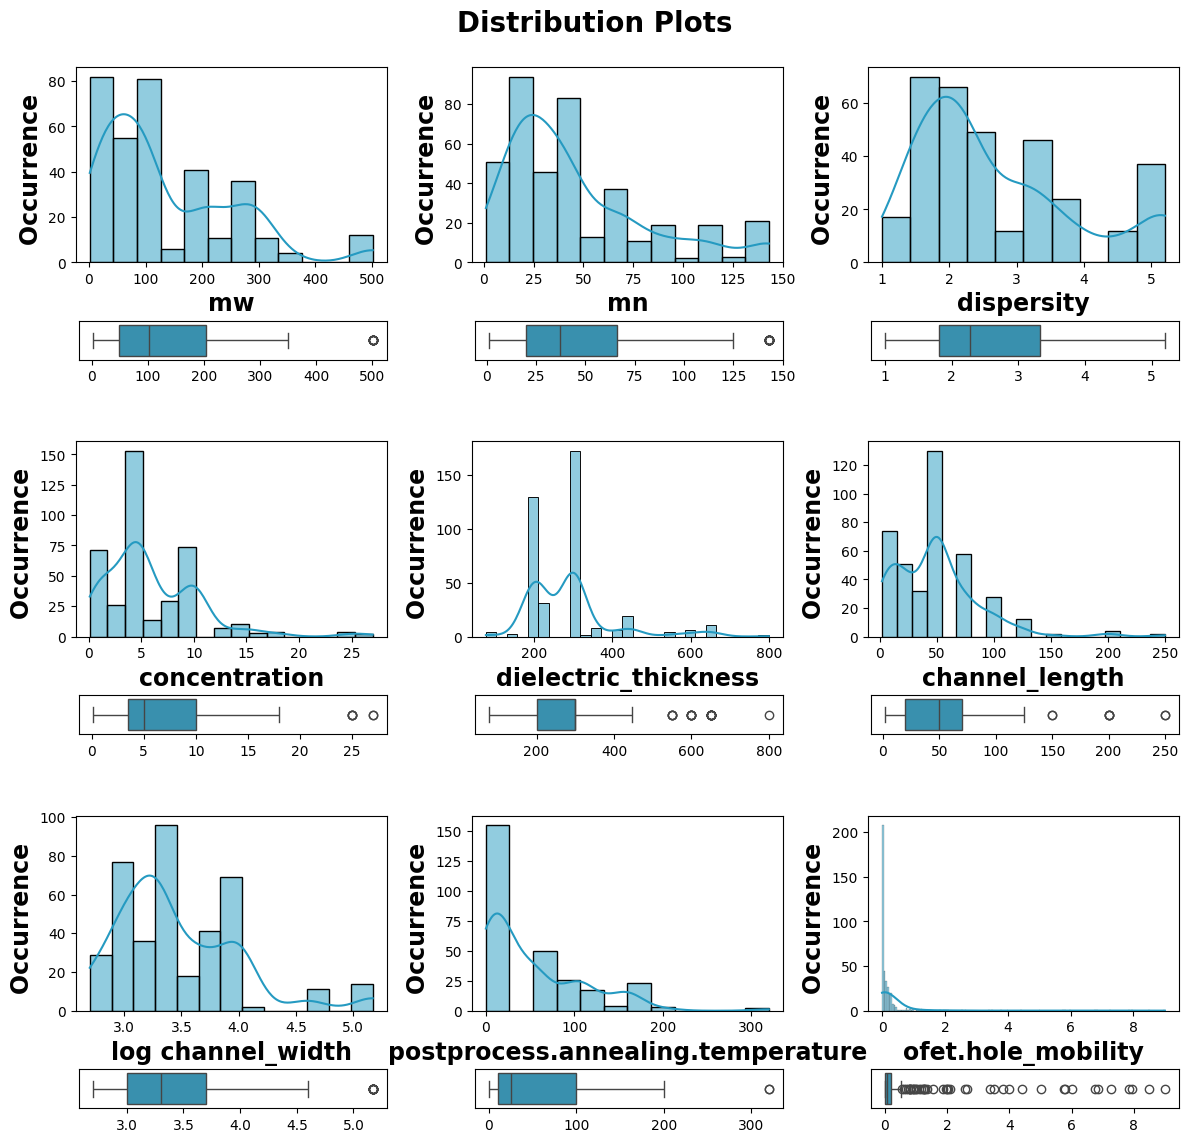

In [17]:
distribution_plot(df=final_working_data, parameters=numerical_params, columns_per_row=3, log_cutoff=100000,figsize=(12,12),title = "Distribution Plots")

 **- I will not replcae or remove outlier as there are both n-type and p-type
conjugated polymer.**

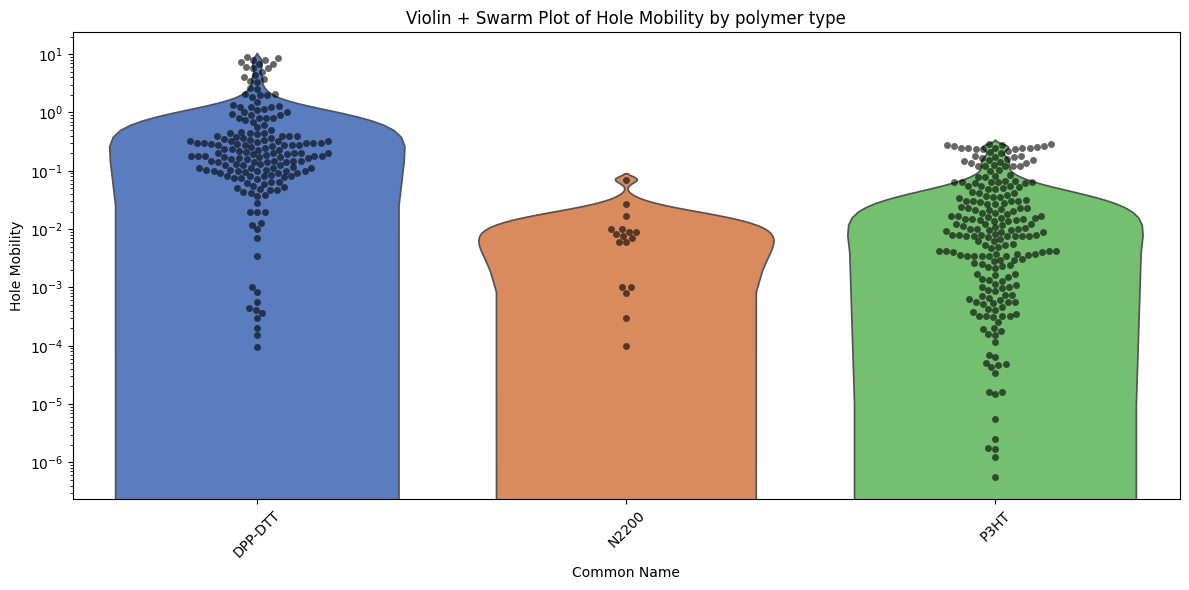

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(
    data=final_working_data,
    x='common_name',
    y='ofet.hole_mobility',
    inner=None,  # Remove inner lines for better swarm overlay
    palette="muted"
)

# Overlay the swarm plot
sns.swarmplot(
    data=final_working_data,
    x='common_name',
    y='ofet.hole_mobility',
    color='k',  # Set swarm points to black
    alpha=0.6   # Set transparency
)

# Add labels and title
plt.xlabel("Common Name")
plt.ylabel("Hole Mobility")
plt.title("Violin + Swarm Plot of Hole Mobility by polymer type")
plt.yscale('log')
# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

### corelation plot before any imputation

In [19]:
def draw_correlation_heatmap(df: pd.DataFrame, parameters: list,title:str=''):
    """
    Draws a heatmap for the Spearman correlation of the specified parameters from the DataFrame.

    Parameters:
    - df: pd.DataFrame - The DataFrame containing the data to analyze.
    - parameters: list - A list of column names to include in the correlation plot.
    """
    # Compute the Spearman correlation matrix
    corrmatrix = df[parameters].corr(method='spearman')
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 14))

    # Draw the heatmap
    ax=sns.heatmap(
            corrmatrix,
            vmin=-1,
            vmax=1,
            linewidths=.5,
            square=True,
            center=0,
            cmap='BrBG',
            cbar_kws={"shrink": .3},
            annot=True,
            fmt=".2f",

            # Format for the correlation coefficient
            )

    # Set title
    plt.title(title, fontsize=16,fontweight='bold')
    for label in ax.get_xticklabels():
        label.set_fontsize(12)
        label.set_fontweight('bold')

    for label in ax.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontweight('bold')

    plt.xticks(rotation=45, ha='right')

    plt.show()  # Show the plot

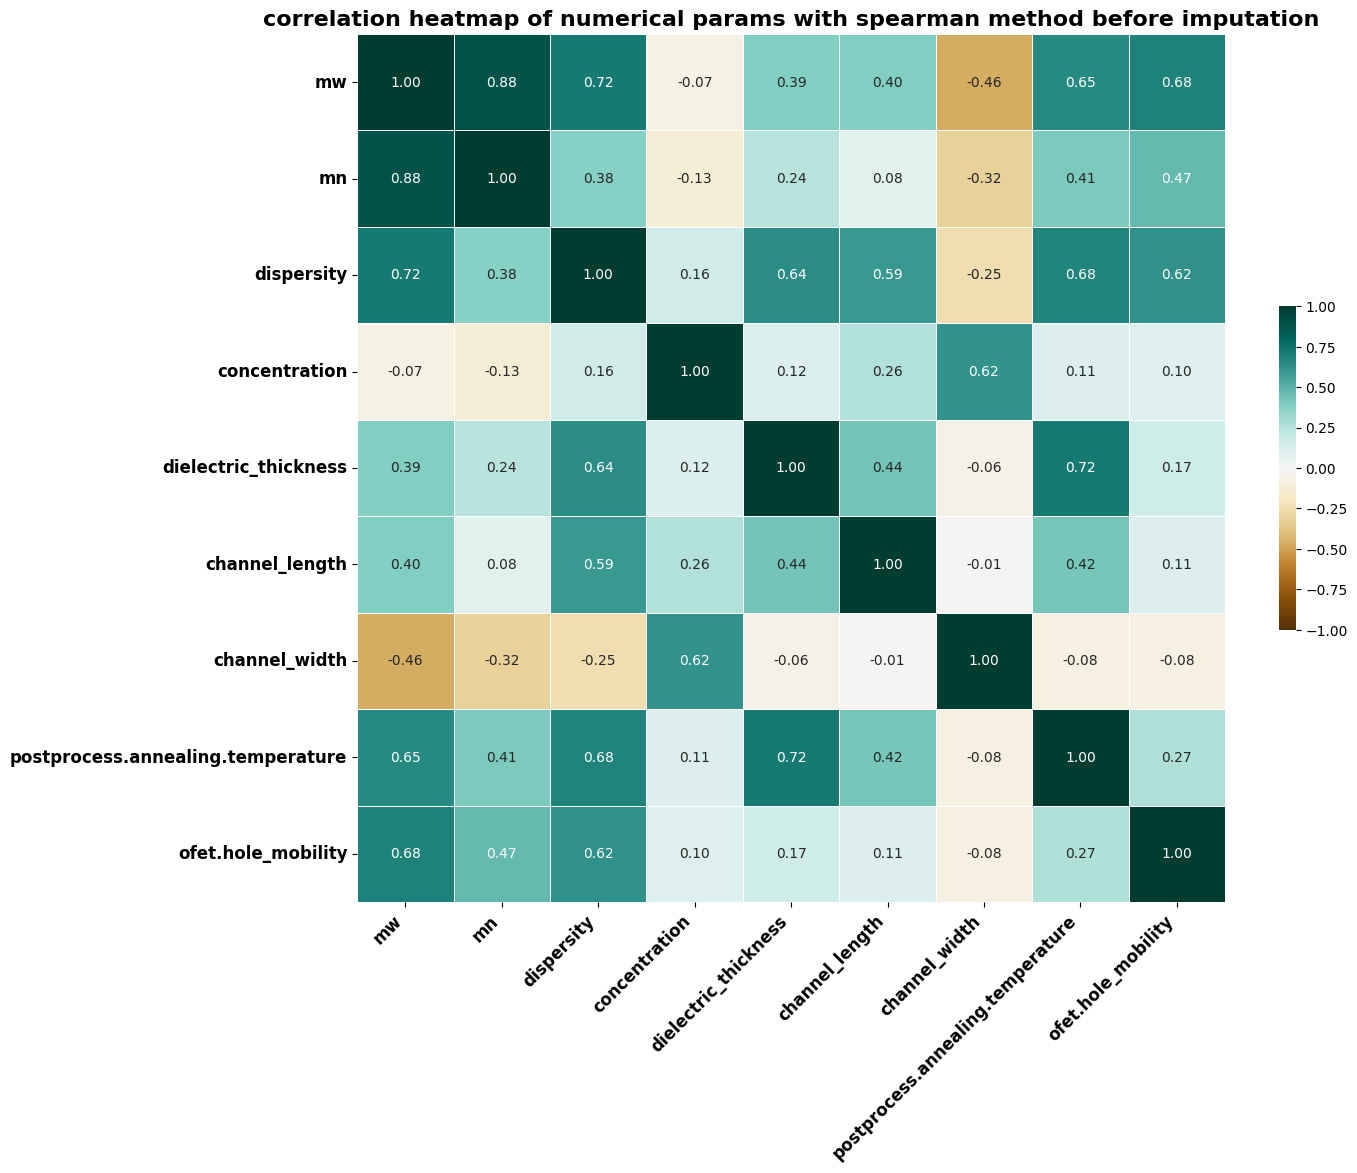

In [20]:
draw_correlation_heatmap(df=final_working_data,parameters=numerical_params,title="correlation heatmap of numerical params with spearman method before imputation")

### pair plot

In [ ]:
# include hue as polymer categories
def draw_pairplot(df: pd.DataFrame, parameters: list, hue: str = None, palette: str = "husl",title: str = ""):
    """
    Draws a pair plot of the specified parameters from the DataFrame.

    Parameters:
    - df: pd.DataFrame - The DataFrame containing the data to plot.
    - parameters: list - A list of column names to include in the pair plot.
    - hue: str, optional - The column name for color encoding. Default is None.
    - palette: str, optional - The color palette to use. Default is "husl".
    """
    data_to_plot = df[parameters]
    plt.figure(figsize=(12, 8))
    pairplot = sns.pairplot(data=data_to_plot, hue=hue, palette=palette)
    if title:
        pairplot.fig.suptitle(title, fontsize=30, fontweight='bold',y=1.01)

    for ax in pairplot.axes.flatten():
      ax.set_xlabel(ax.get_xlabel(), fontsize=20, fontweight='bold',rotation=90)  # Set x label font
      ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold',rotation=0)  # Set y label font
      ax.yaxis.get_label().set_horizontalalignment('right')
    # plt.tight_layout()
    # plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)
    plt.show()


<Figure size 1200x800 with 0 Axes>

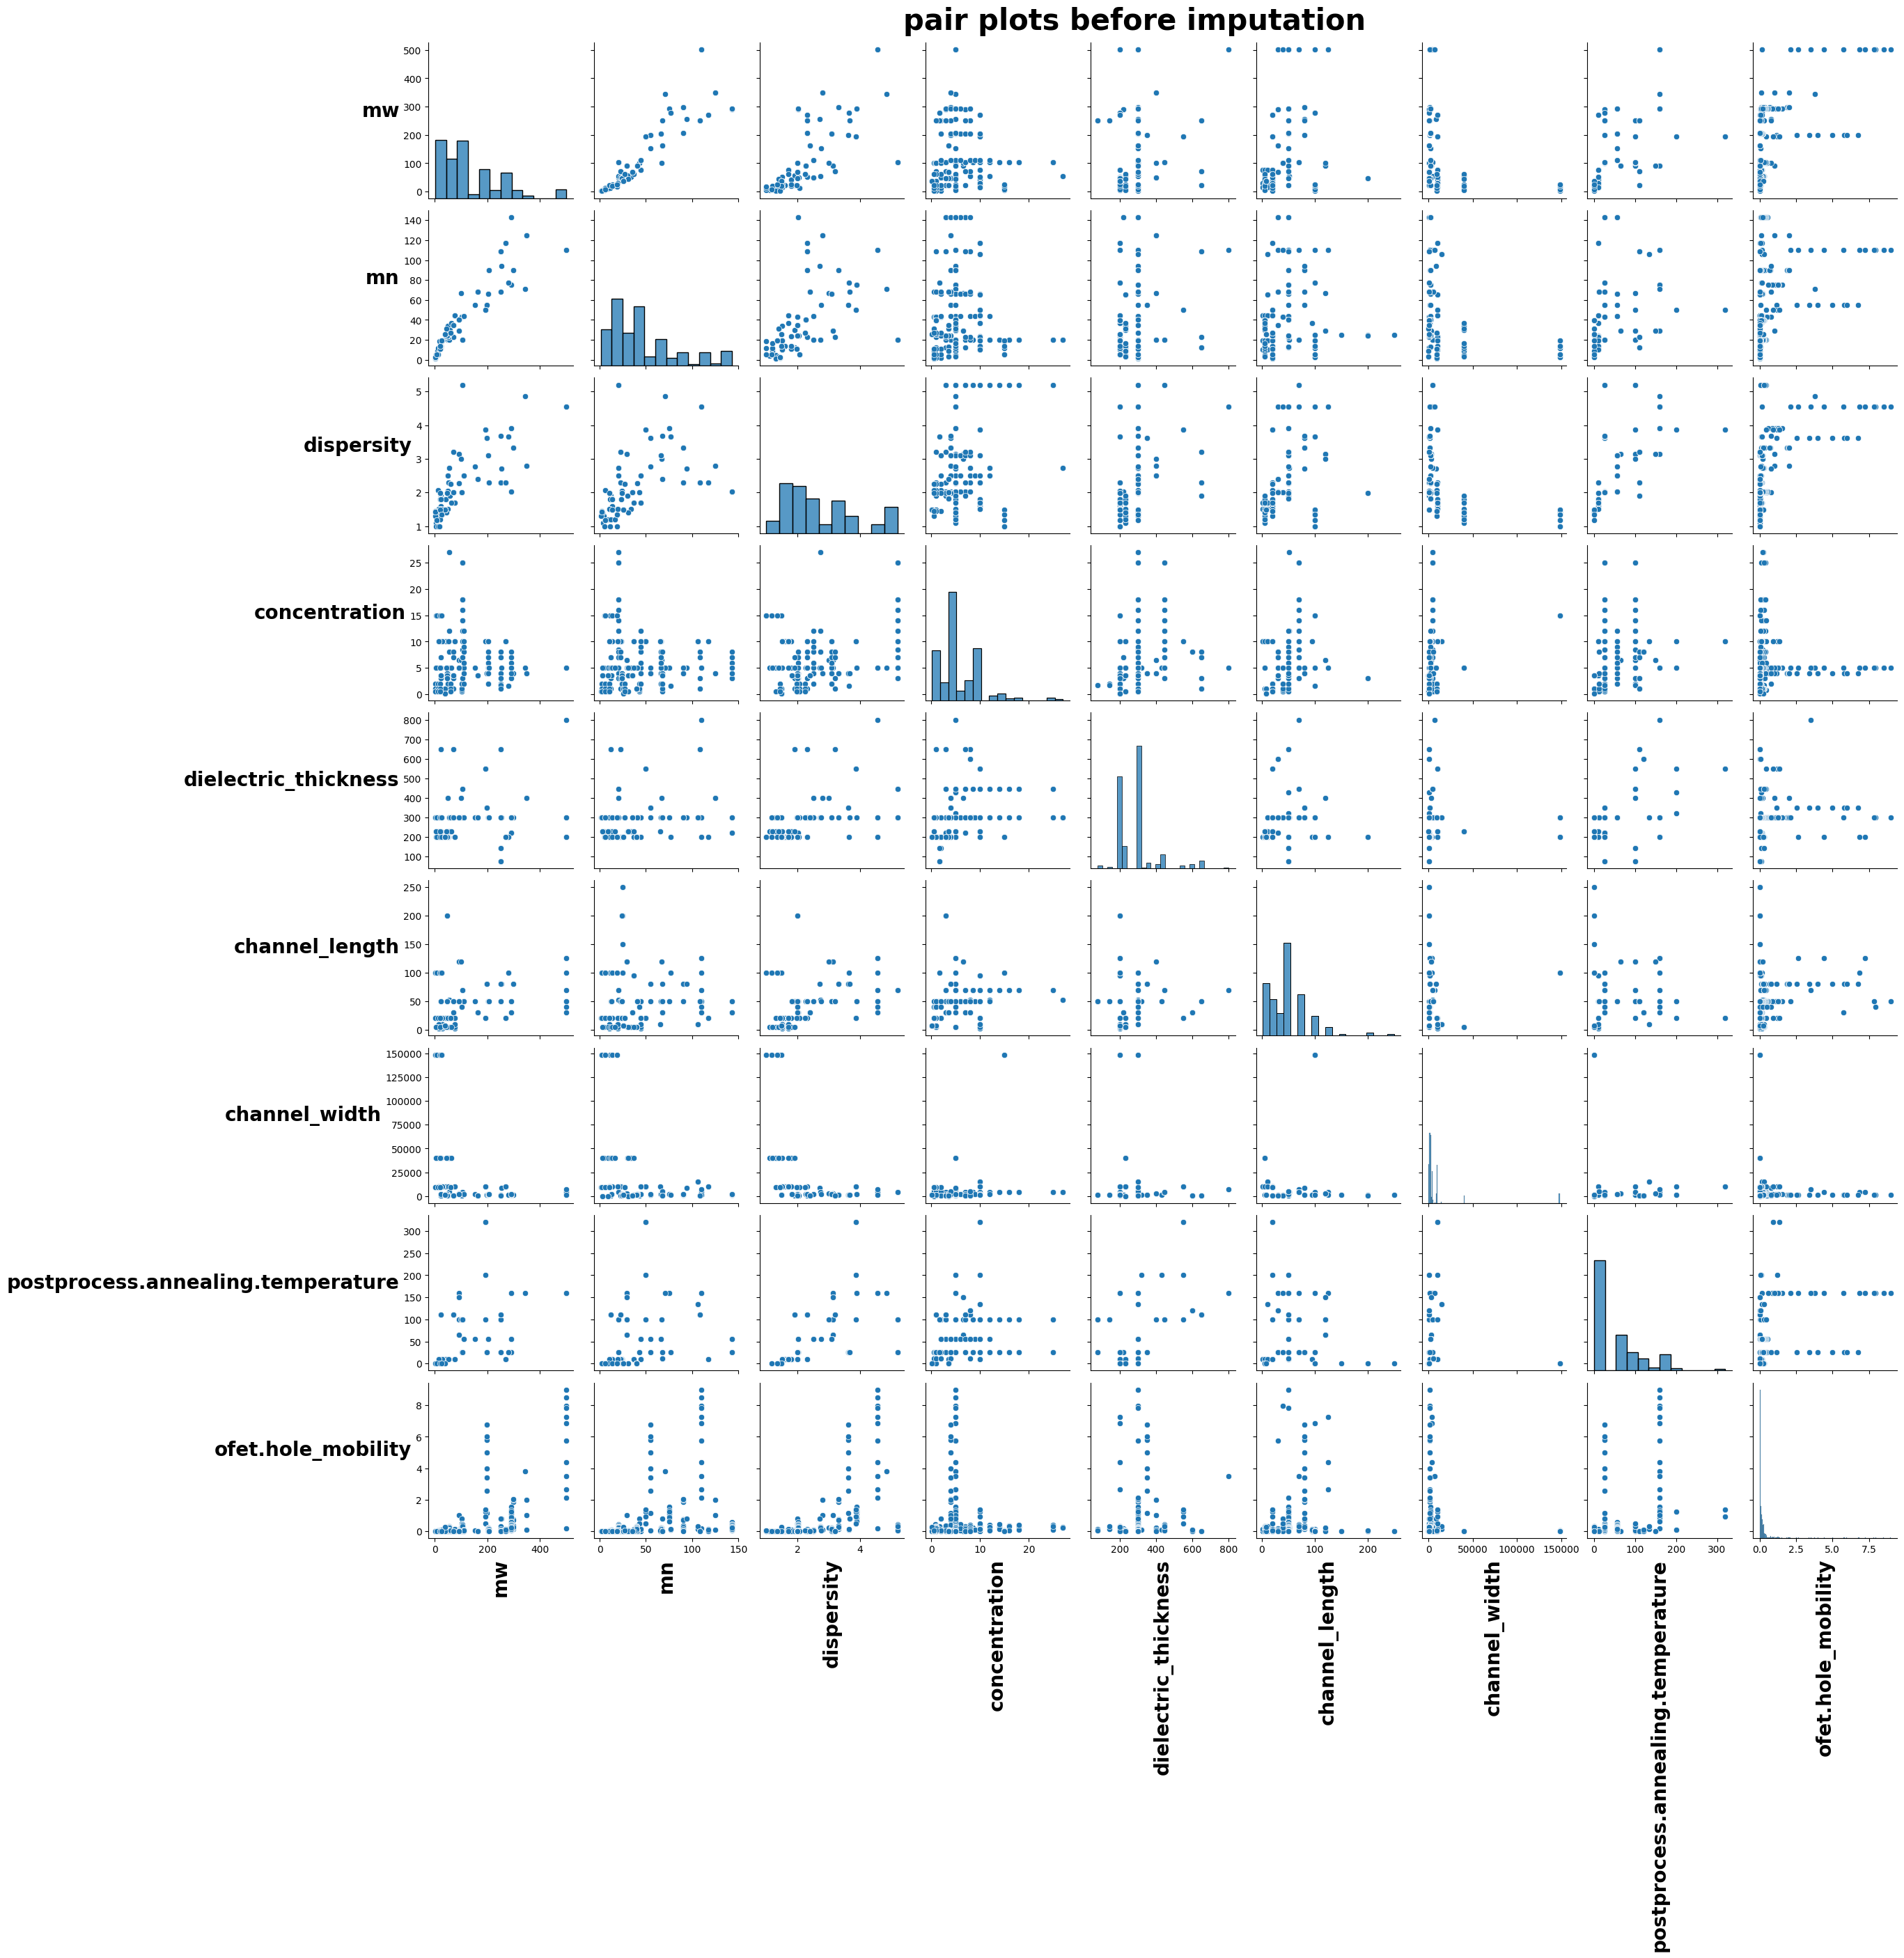

In [ ]:
draw_pairplot(df=final_working_data,parameters=numerical_params,title="pair plots before imputation")

### encode the categorical parameters
Except: materials and solvents(Featurzing in future (using molecular descriptors and Hanson solubility parameters ea. ECFP, Mordred))

In [22]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [23]:
object_params = [
    'iupac_name.1',
    'iupac_name_2.1',
    'gate_material',
    'dielectric_material',
    'electrode_material',
    'electrode_configuration',
    'deposition_type',
    'params.environment',
    'ofet.environment'
]
final_working_data_categorical_included = final_working_data.copy()

In [24]:
params_to_encode = ['deposition_type', 'electrode_configuration',  'params.environment', 'ofet.environment' ]

In [25]:
le = LabelEncoder()
# Apply LabelEncoder to each column
for col in params_to_encode:
    # Create encoded column
    final_working_data_categorical_included[f'{col} encoded'] = le.fit_transform(final_working_data_categorical_included[col])

    # Drop the original column
    final_working_data_categorical_included.drop(columns=[col], inplace=True)



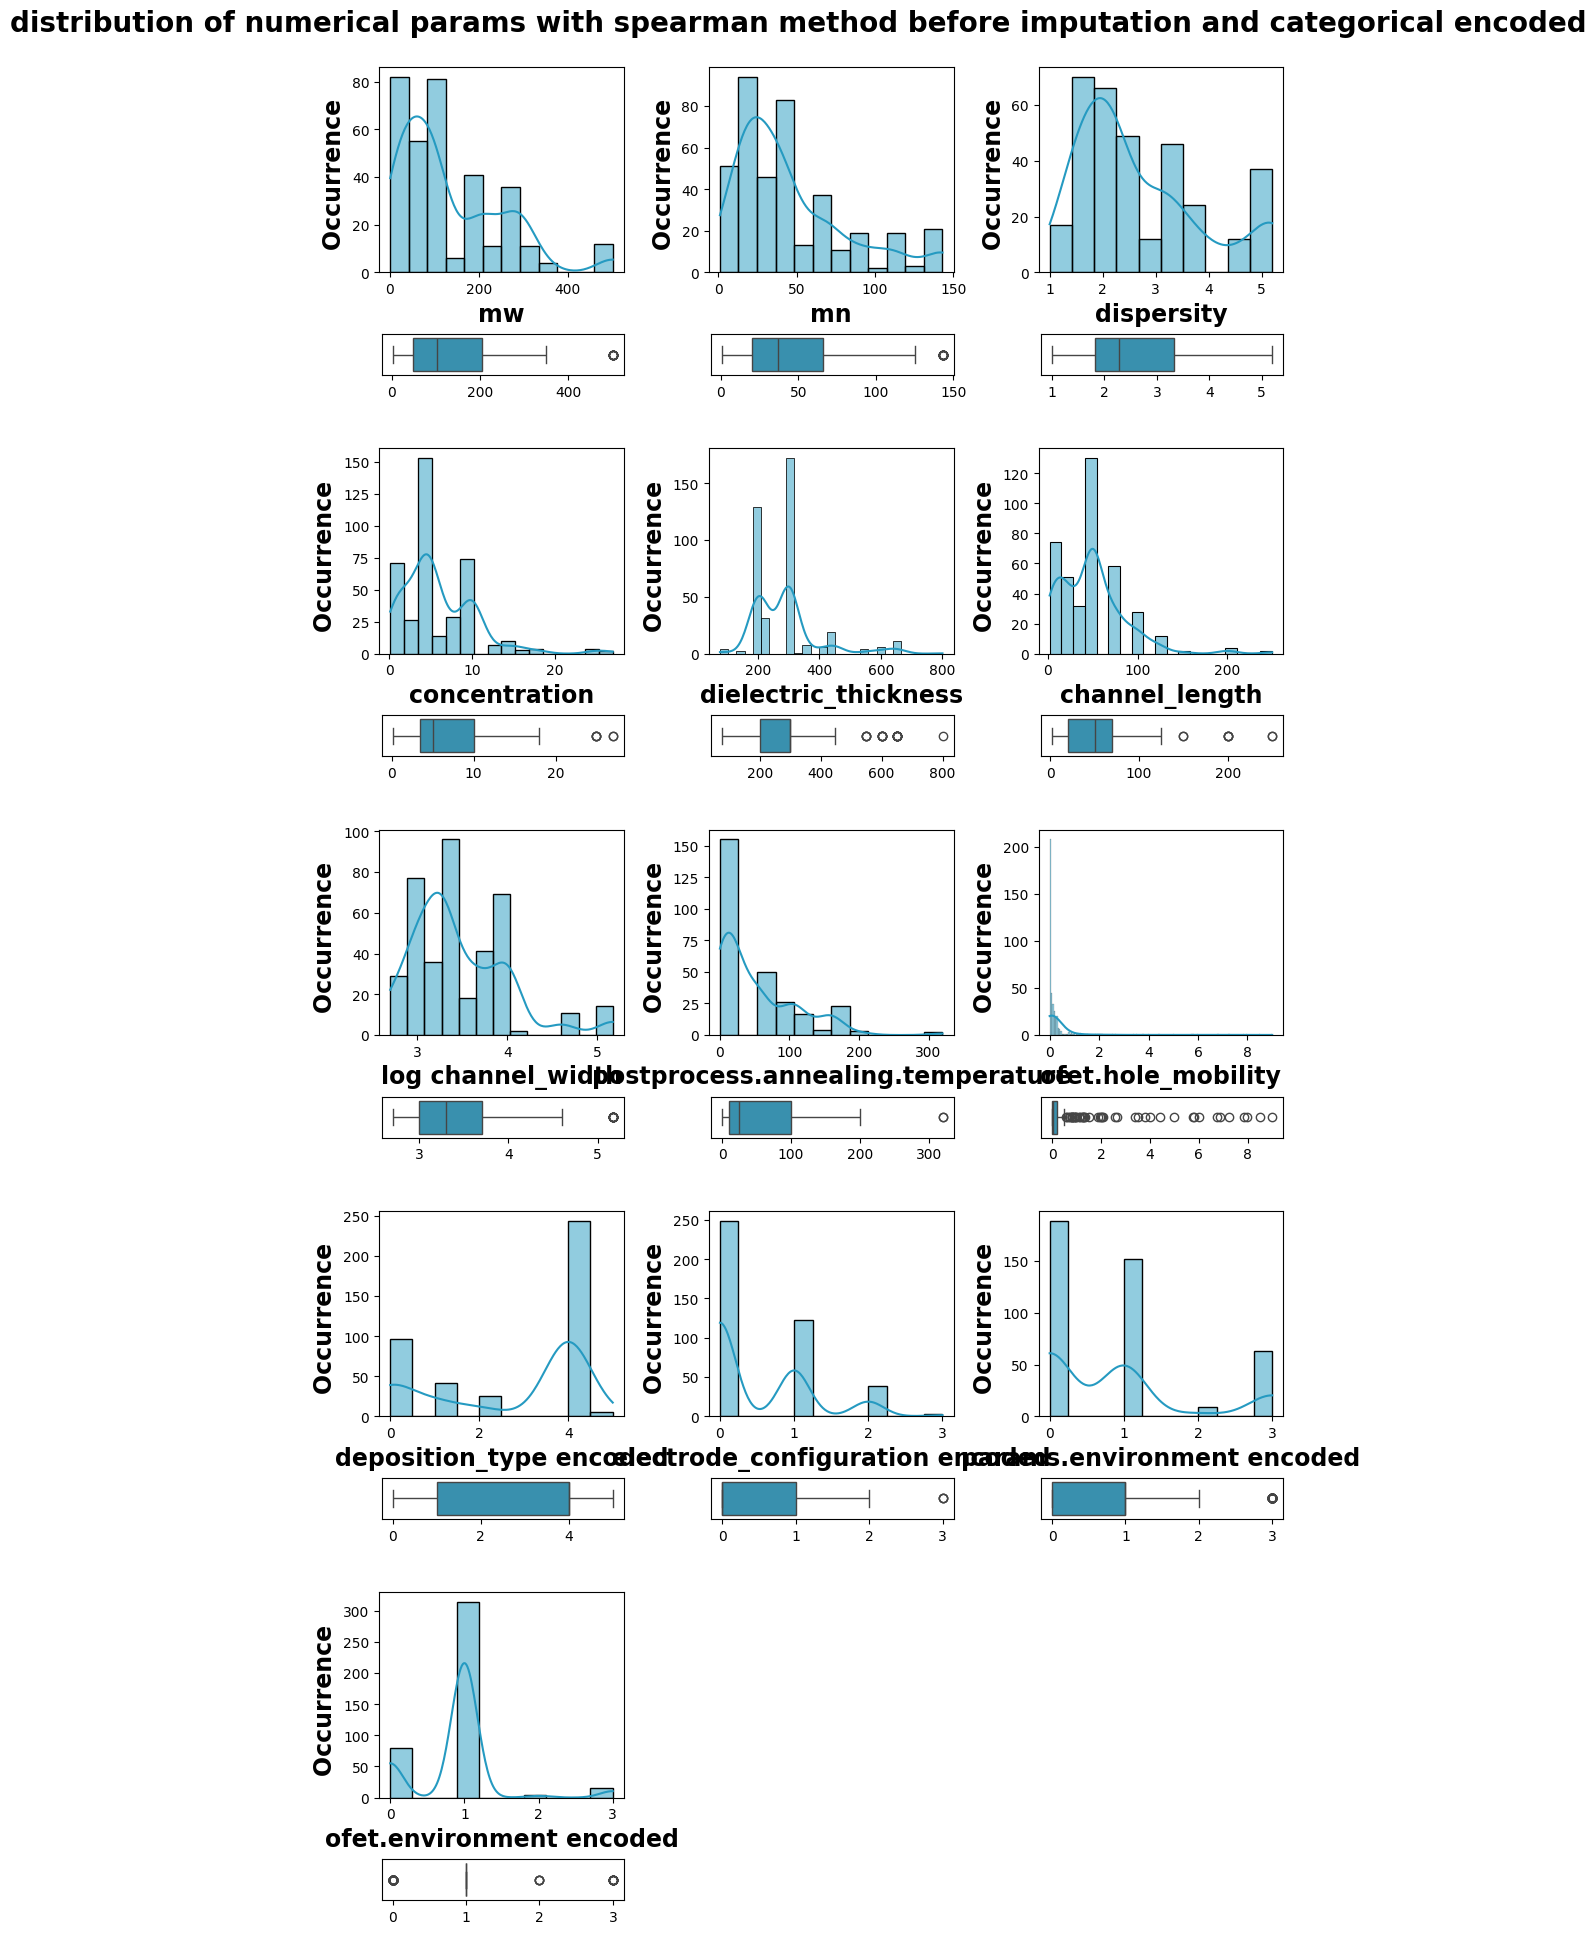

In [35]:
distribution_plot(df=final_working_data_categorical_included, parameters=params_to_show, columns_per_row=3, log_cutoff=100000,figsize=(10,20),title = "distribution of numerical params with spearman method before imputation and categorical encoded")

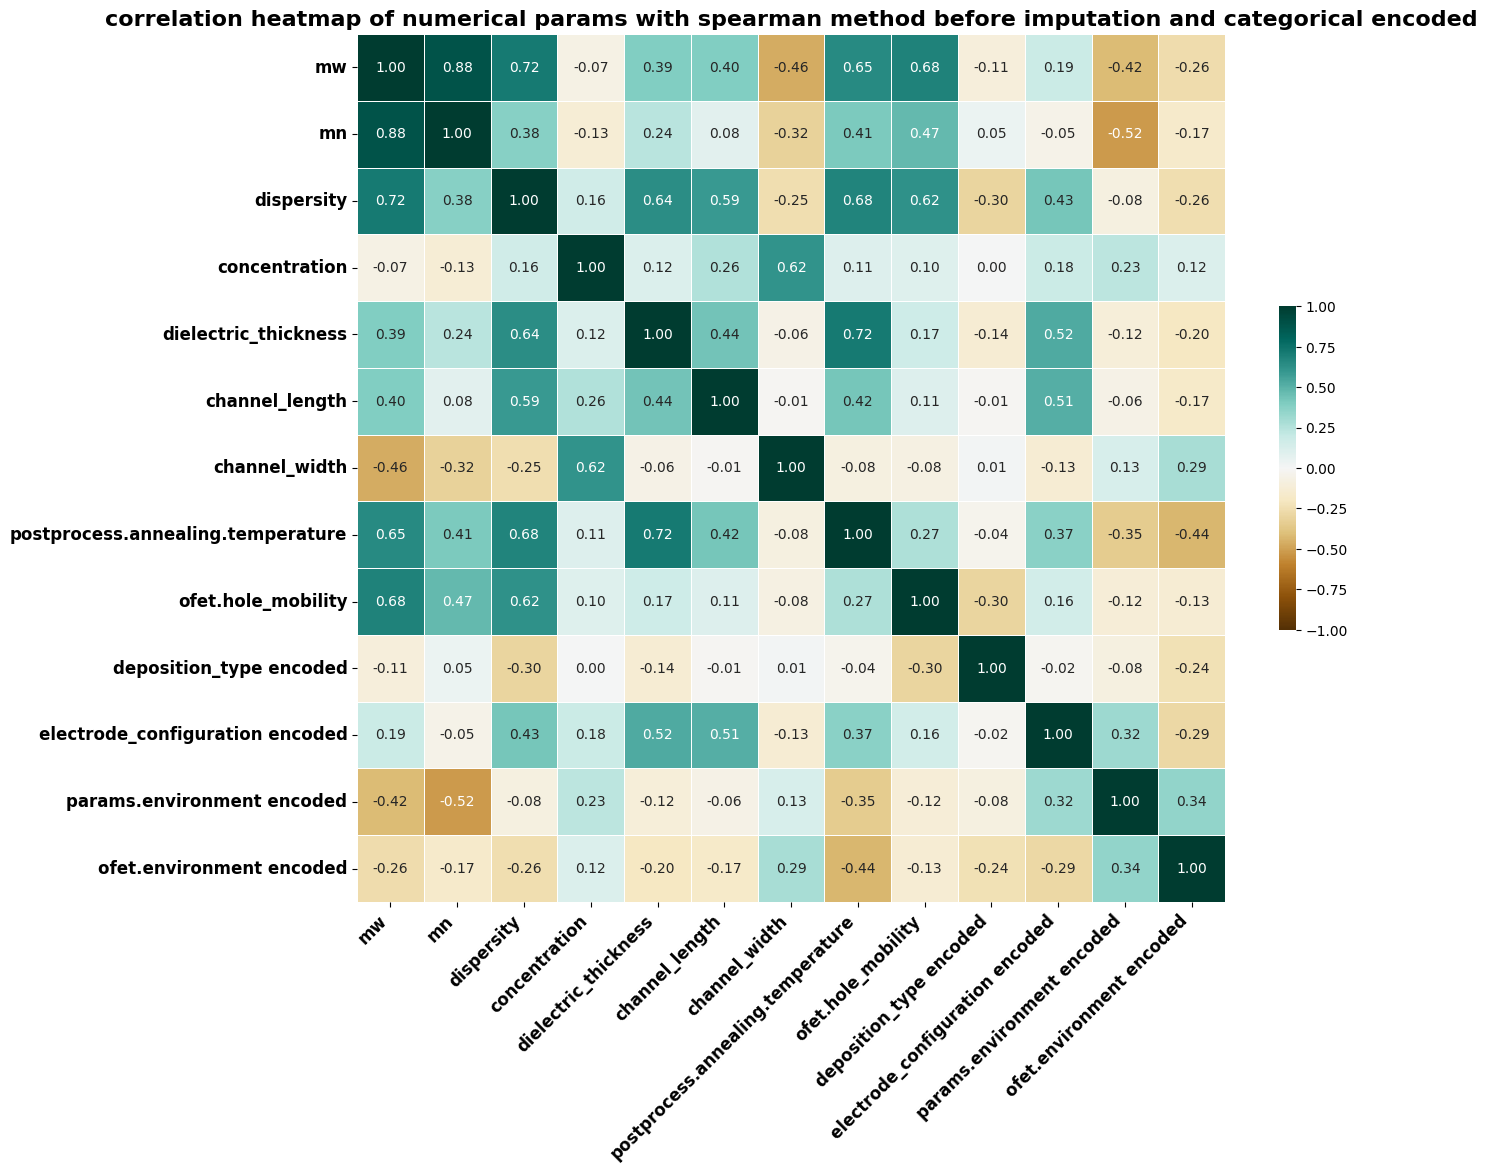

In [27]:
draw_correlation_heatmap(df=final_working_data_categorical_included,parameters=params_to_show,title="correlation heatmap of numerical params with spearman method before imputation and categorical encoded")

In [ ]:
draw_correlation_heatmap(df=final_working_data_categorical_included,parameters=params_to_show,title="correlation heatmap of numerical params with spearman method before imputation and categorical encoded")

<Figure size 1200x800 with 0 Axes>

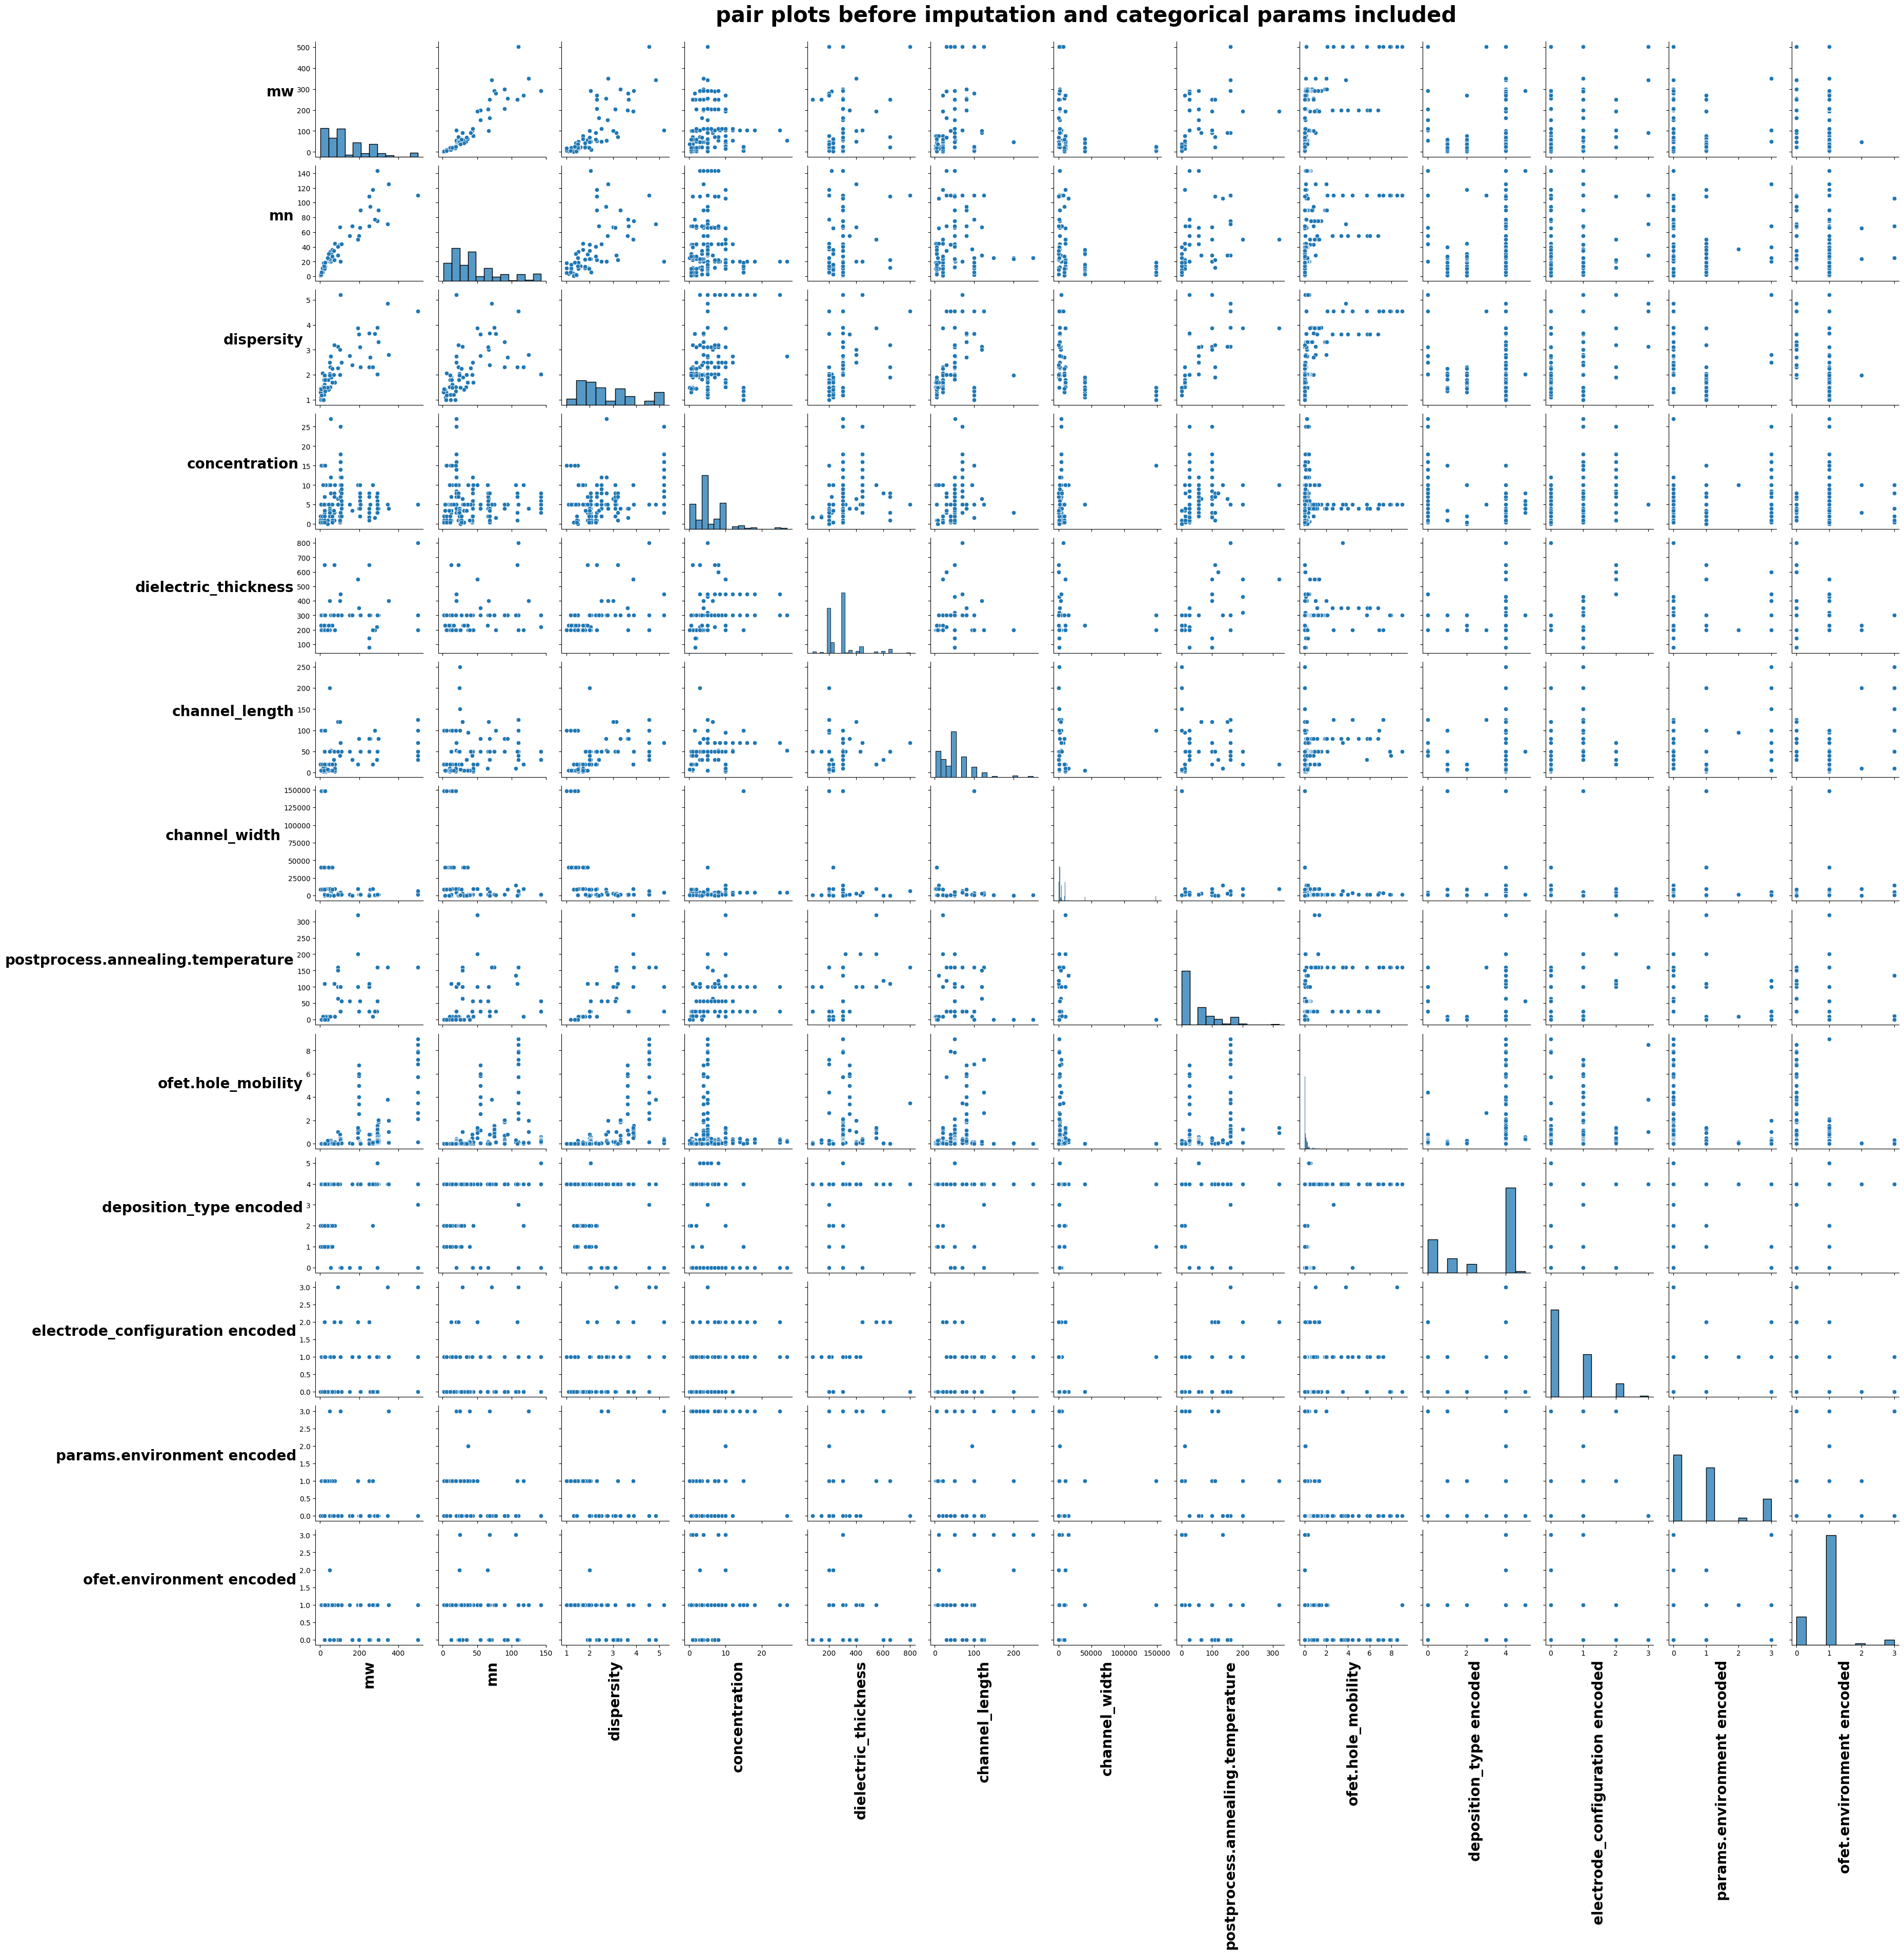

In [ ]:
draw_pairplot(df=final_working_data_categorical_included,parameters=params_to_show,title="pair plots before imputation and categorical params included")

### impute numerical params

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [38]:
def impute_data(df, columns_to_impute, method='mean', n_neighbors=5):
    """
    Impute missing data in specific columns using the specified method:
    (a) 'mean' imputation
    (b) 'most_frequent' imputation
    (c) 'knn' imputation (using k-Nearest Neighbors)

    Parameters:
    - df: DataFrame with missing values
    - columns_to_impute: List of column names to impute
    - method: The imputation method to use ('mean', 'most_frequent', 'knn')
    - n_neighbors: The number of neighbors to use for kNN imputation (default is 5)

    Returns:
    - df_imputed: DataFrame with imputed values in the specified columns
    """

    df_copy = df.copy()  # Make a copy of the original DataFrame to avoid modifying it directly

    # Impute specified columns
    for column in columns_to_impute:
        if column in df_copy.columns:
            if method == 'mean':
                # Mean imputation
                imputer = SimpleImputer(strategy='mean')
                df_copy[column] = imputer.fit_transform(df_copy[[column]])

            elif method == 'most_frequent':
                # Most frequent value imputation
                imputer = SimpleImputer(strategy='most_frequent')
                df_copy[column] = imputer.fit_transform(df_copy[[column]])

            elif method == 'knn':
                # kNN imputation
                imputer = KNNImputer(n_neighbors=n_neighbors)
                df_copy[column] = imputer.fit_transform(df_copy[[column]])

            else:
                raise ValueError("Invalid method. Choose from 'mean', 'most_frequent', or 'knn'.")
        else:
            print(f"Warning: Column '{column}' not found in DataFrame.")

    return df_copy

In [39]:
feats_to_impute = ['mn', 'mw', 'concentration','dielectric_thickness','channel_length',
    'channel_width','postprocess.annealing.temperature']


In [40]:
df_mean_imputed = impute_data(final_working_data_categorical_included,feats_to_impute, method='mean')
df_mean_imputed['dispersity'] = df_mean_imputed['mw'] / df_mean_imputed['mn']

df_most_frequent_imputed = impute_data(final_working_data_categorical_included, feats_to_impute,method='most_frequent')
df_most_frequent_imputed['dispersity'] = df_most_frequent_imputed['mw'] / df_most_frequent_imputed['mn']

df_knn_imputed = impute_data(final_working_data_categorical_included, feats_to_impute,method='knn', n_neighbors=5)
df_knn_imputed['dispersity'] = df_knn_imputed['mw'] / df_knn_imputed['mn']


In [41]:
df_knn_imputed.columns

Index(['common_name', 'mw', 'mn', 'dispersity', 'iupac_name.1',
       'iupac_name_2.1', 'vol_frac_2', 'concentration', 'vol_frac',
       'gate_material', 'dielectric_material', 'dielectric_thickness',
       'electrode_material', 'channel_length', 'channel_width',
       'postprocess.annealing.temperature', 'ofet.hole_mobility',
       'deposition_type encoded', 'electrode_configuration encoded',
       'params.environment encoded', 'ofet.environment encoded'],
      dtype='object')

### distribution after imputation

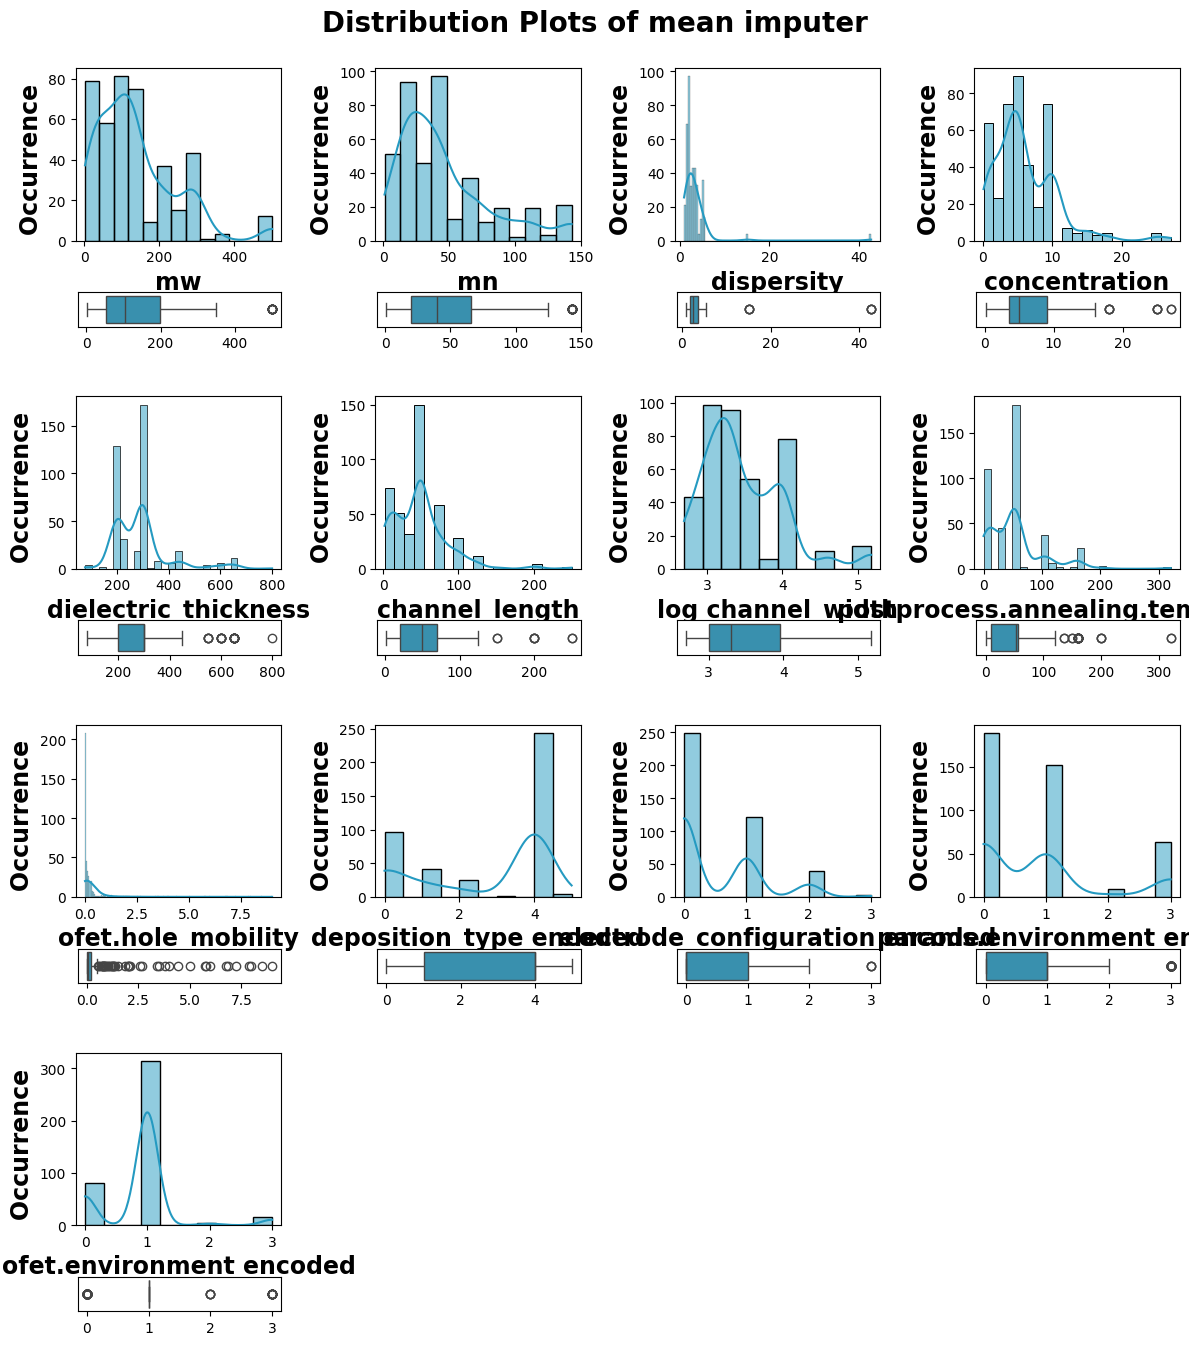

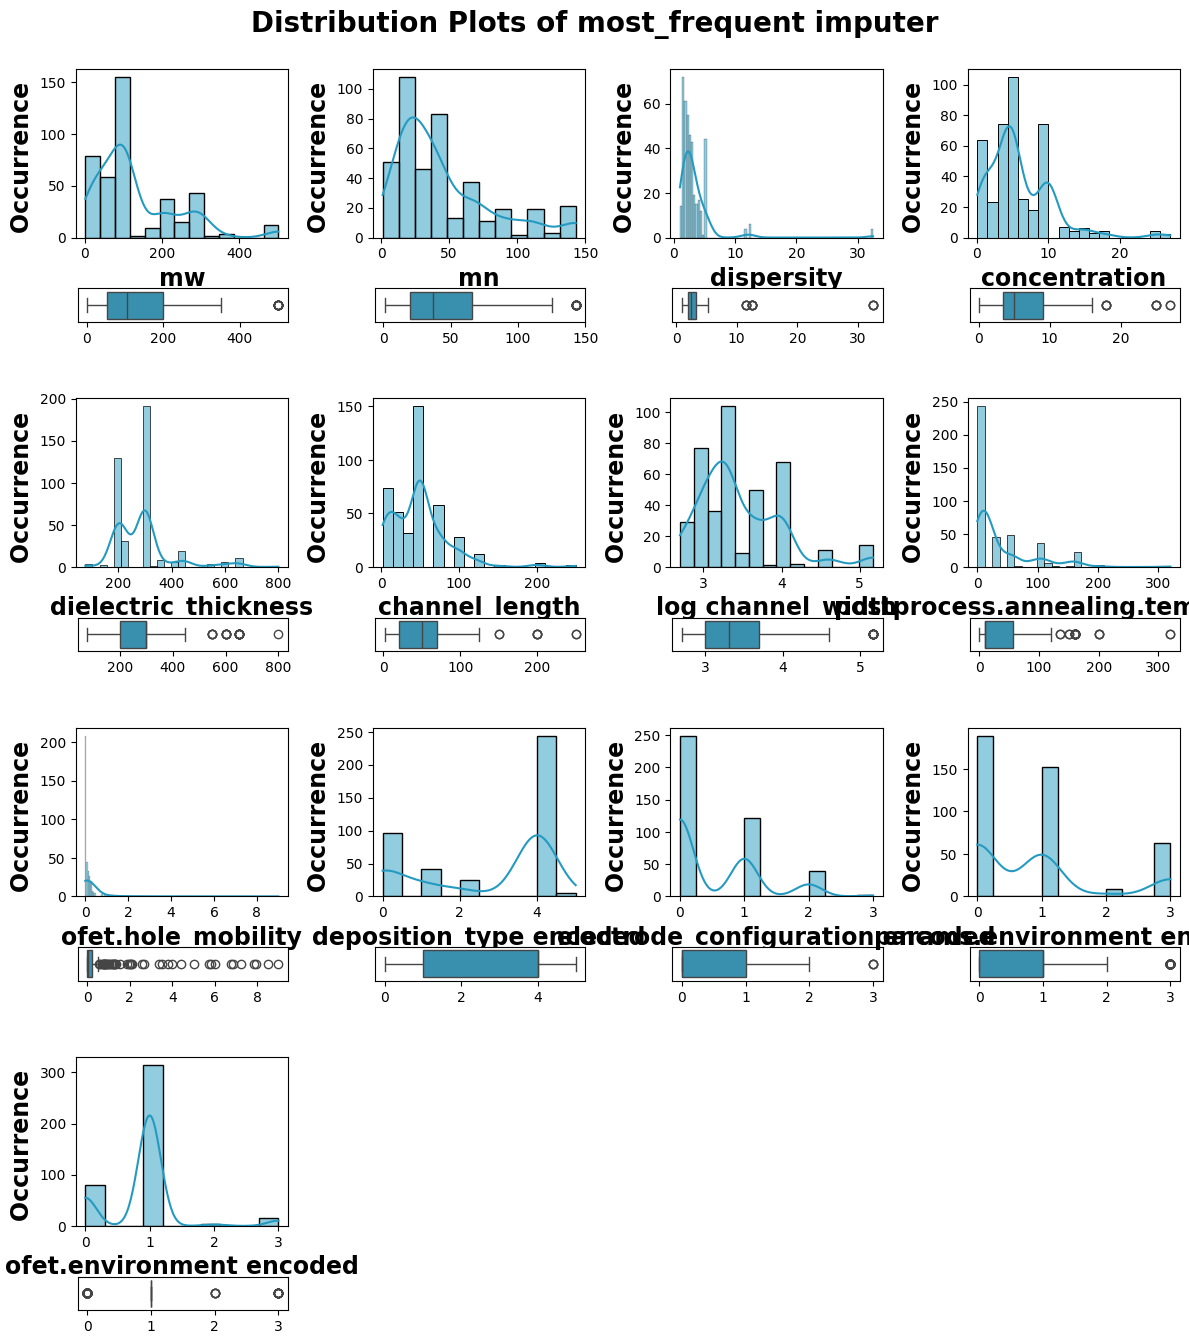

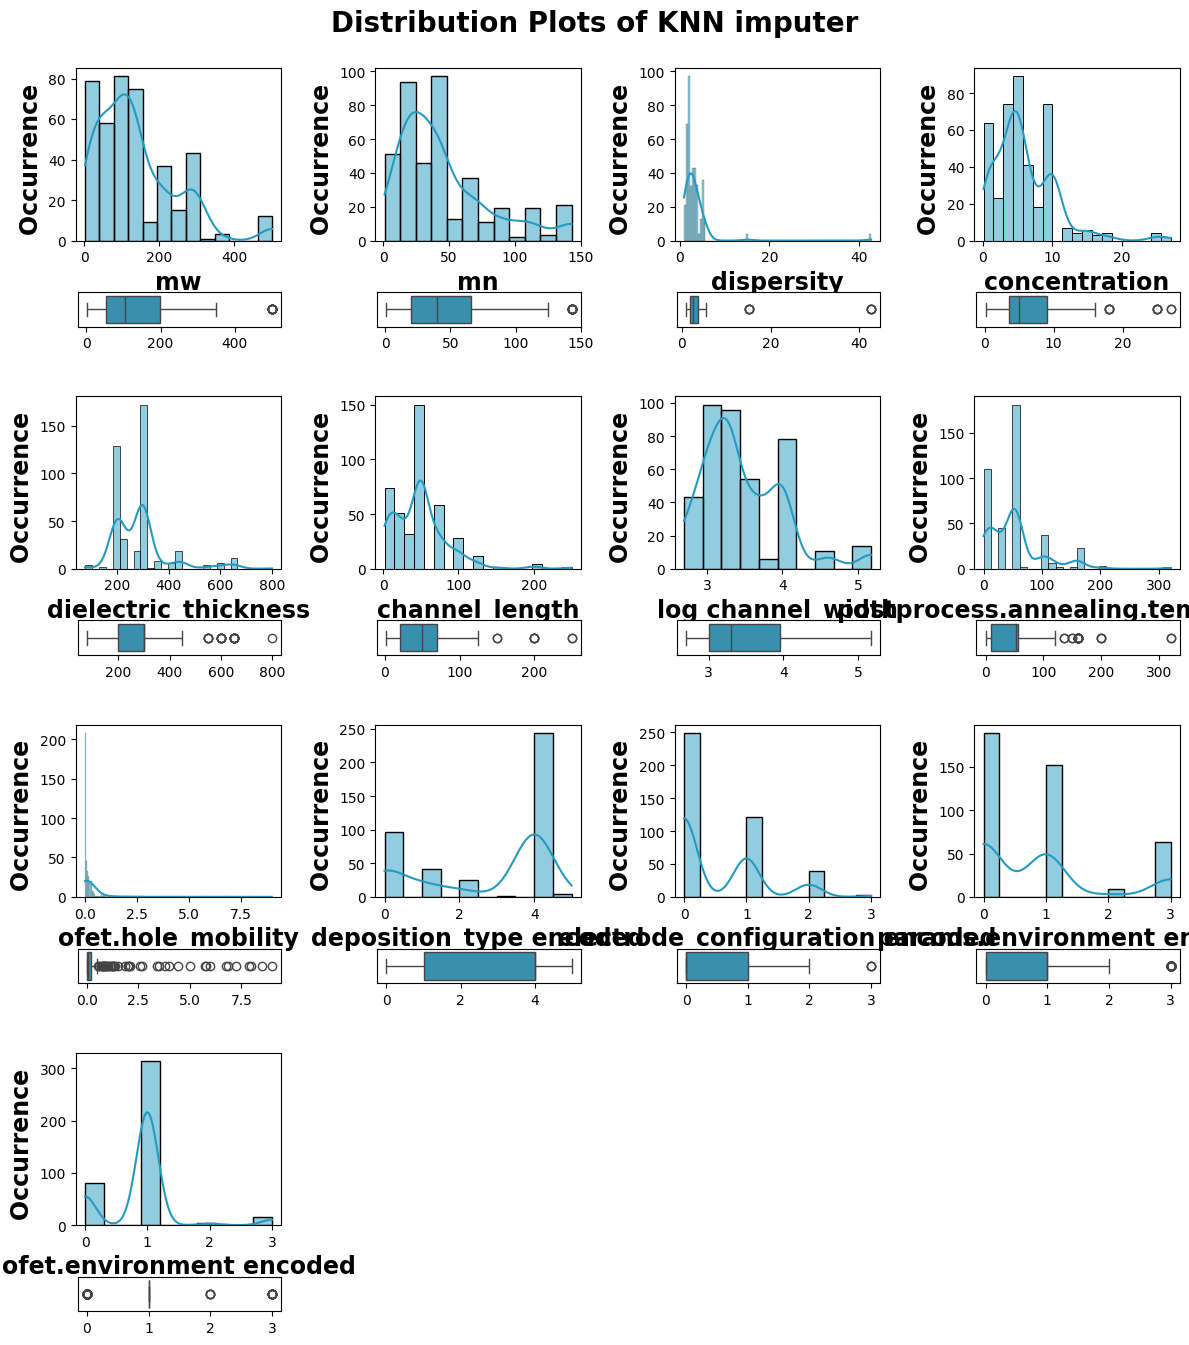

In [42]:
for dataset,imputer in zip([df_mean_imputed,df_most_frequent_imputed,df_knn_imputed],['mean','most_frequent', 'KNN']):
  distribution_plot(df=dataset, parameters=params_to_show, columns_per_row=4, log_cutoff=100000,figsize=(12,14),title = f"Distribution Plots of {imputer} imputer")

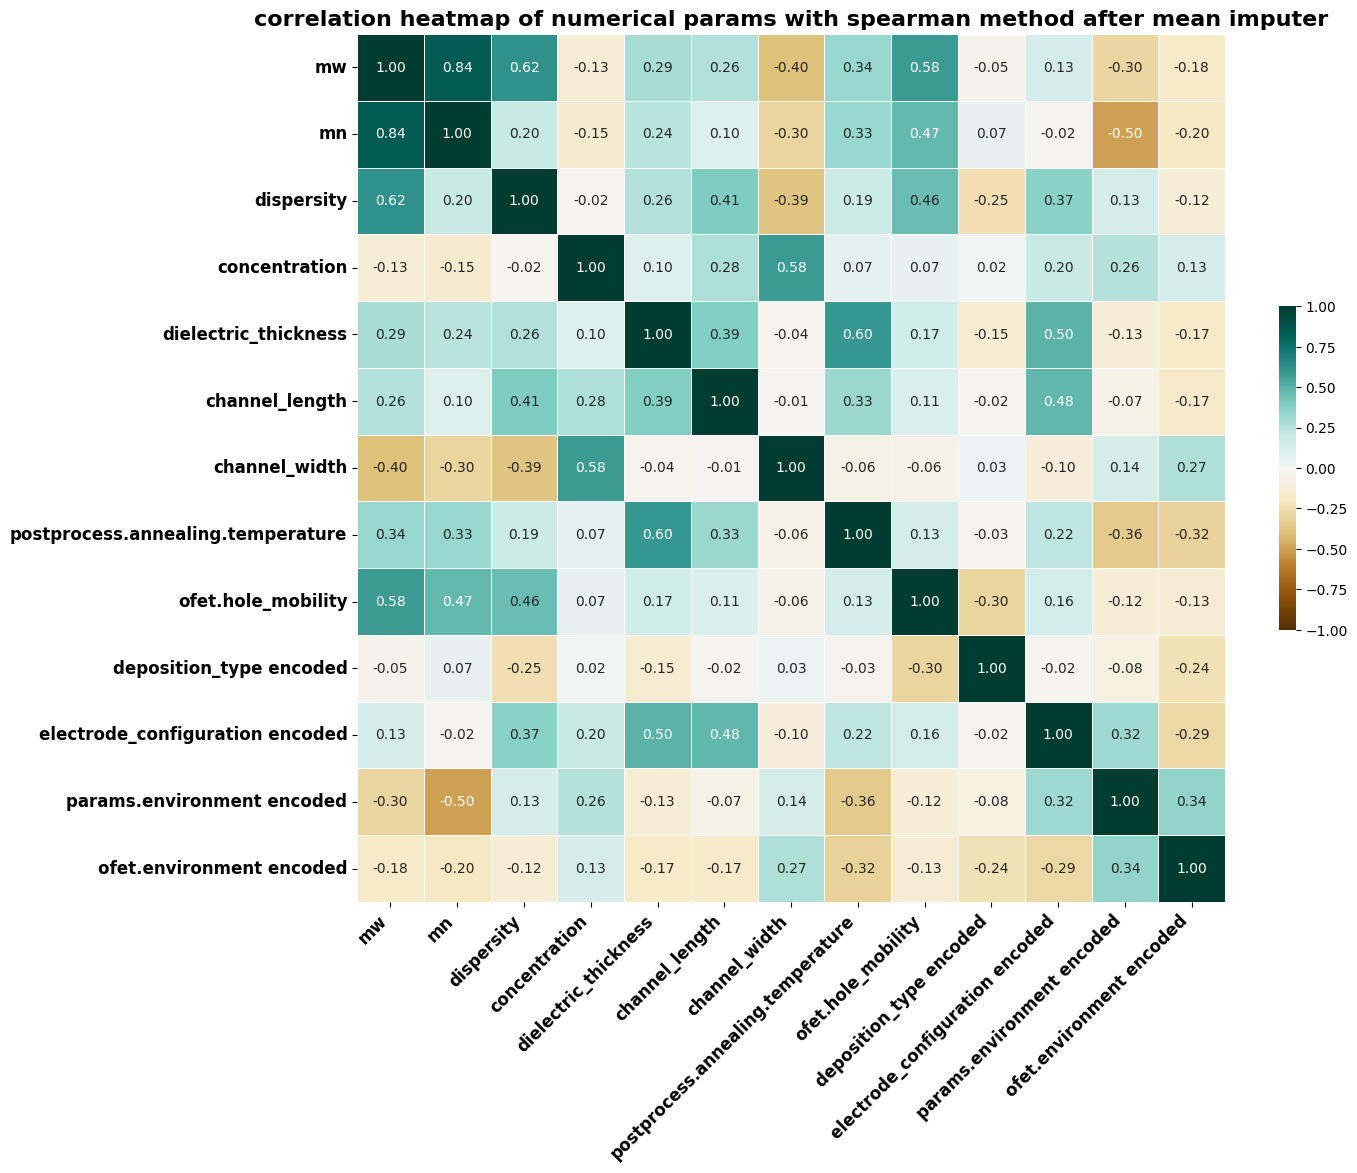

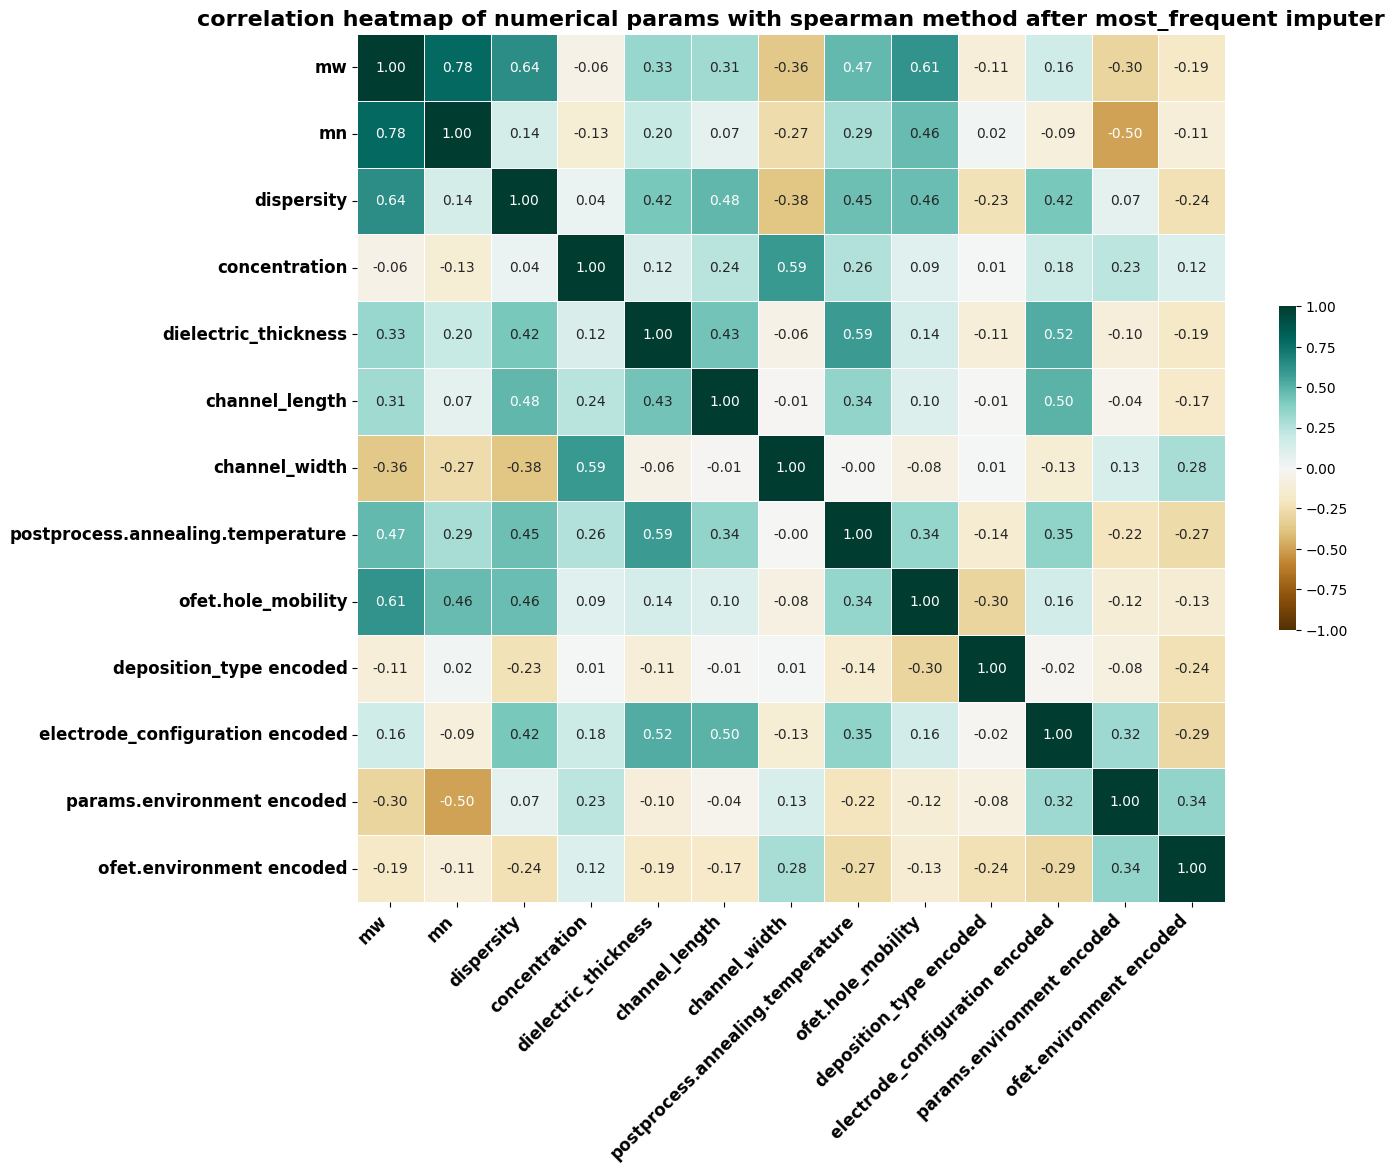

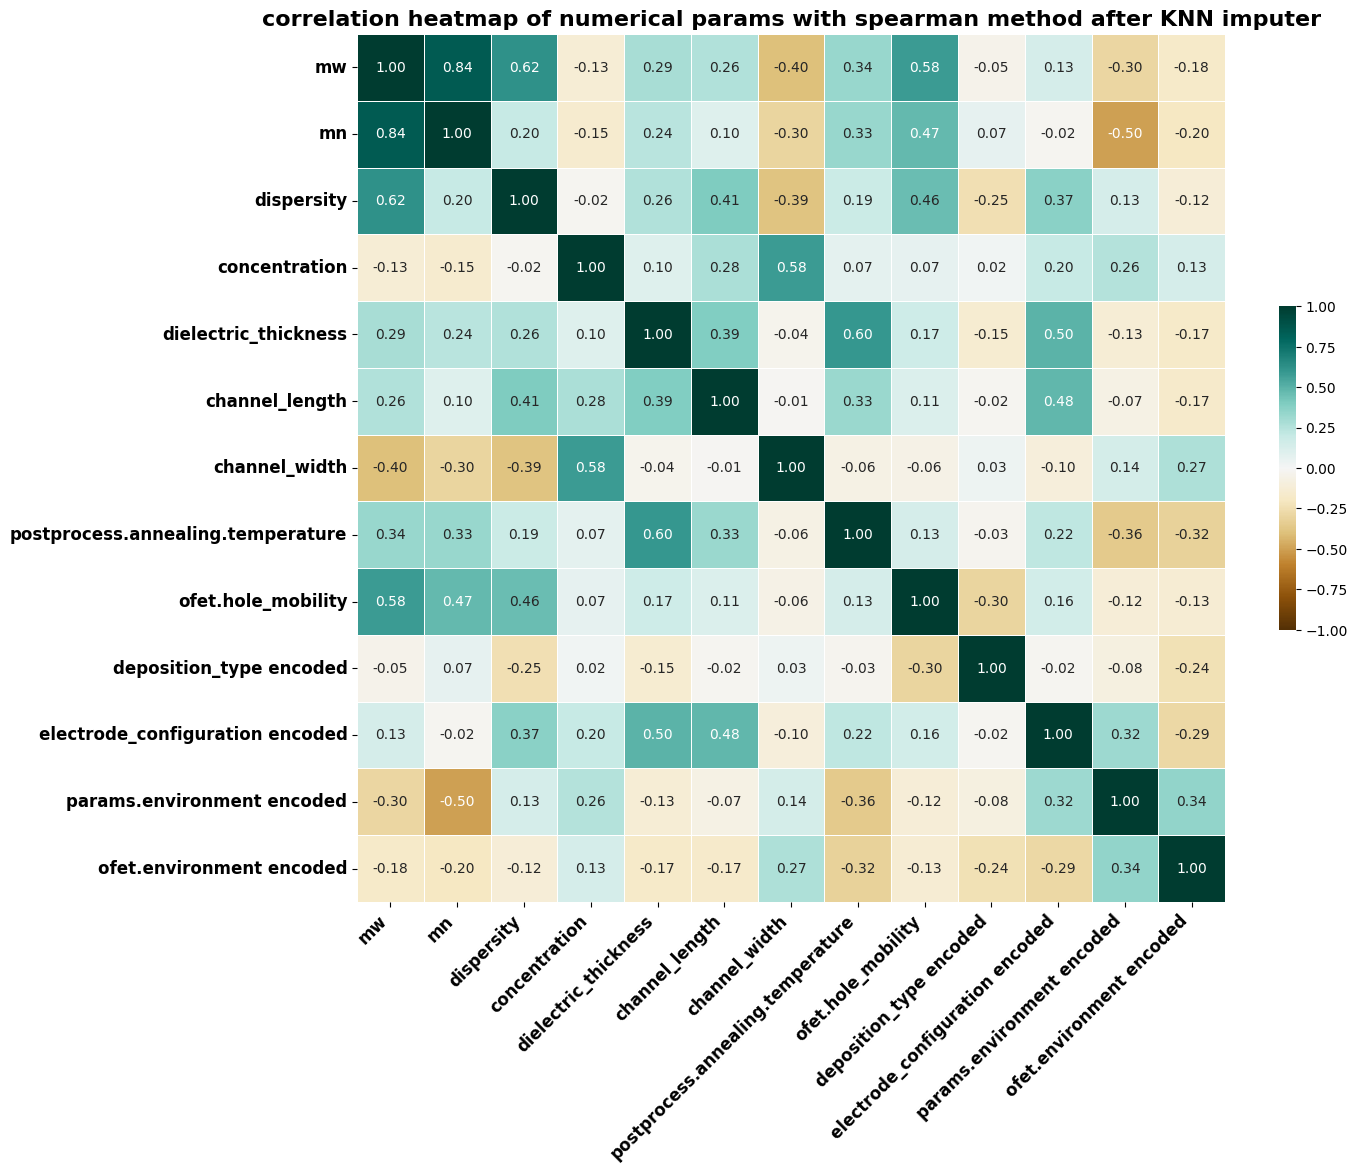

In [43]:
for dataset,imputer in zip([df_mean_imputed,df_most_frequent_imputed,df_knn_imputed],['mean','most_frequent', 'KNN']):
  # distribution_plot(df=dataset, parameters=params_to_show, columns_per_row=4, log_cutoff=100000,figsize=(12,14),title = f"Distribution Plots of {imputer} imputer")
  draw_correlation_heatmap(df=dataset,parameters=params_to_show,title=f"correlation heatmap of numerical params with spearman method after {imputer} imputer")

In [ ]:
print(df_mean_imputed['common_name'].unique())
print(df_mean_imputed['iupac_name.1'].unique())
print(df_mean_imputed['iupac_name_2.1'].unique())

polymer_bank:pd.DataFrame = pd.DataFrame({
    "polymer_name" :["P3HT", "DPP-DTT", "N2200"],
    "poly_smile": ["*c1cc(CCCCCC)c(*)s1","*c6ccc(c5c4c(=O)n(CC(CCCCCCCC)CCCCCCCCCC)c(c3ccc(c2cc1sc(*)cc1s2)s3)c4c(=O)n5CC(CCCCCCCC)CCCCCCCCCC)s6",
                   "*c6ccc(c5ccc(c1cc3c(=O)n(CC(CCCCCCCC)CCCCCCCCCC)c(=O)c4c(*)cc2c(=O)n(CC(CCCCCCCC)CCCCCCCCCC)c(=O)c1c2c34)s5)s6"],
    "dD": [17.6, 19.2, 18.5],
    "dP": [2.4, 1.2, 0.4],
    "dH": [4.3, 4.9, 2.4],
})


['DPP-DTT' 'N2200' 'P3HT']
['chlorobenzene' 'chloroform' '1,2-dichlorobenzene' nan
 '1,1,2,2-tetrachloroethane' '1,4-xylene' 'cyclohexylbenzene'
 '1,2,4-trichlorobenzene' 'thiophene' 'toluene' 'styrene' 'benzene']
[nan '1,2-dichlorobenzene']


In [ ]:
# impute the missing value of solvent with mode
mode_category = df_mean_imputed['iupac_name.1'].mode()[0]
df_mean_imputed['iupac_name.1'].fillna(mode_category, inplace=True)


In [ ]:
def get_polymer_hsp_value(polymer_hsp_df,polymer_name, hsp_param):
    row = polymer_hsp_df[polymer_hsp_df['polymer_name'] == polymer_name]
    if not row.empty:
        return row[hsp_param].values[0]
    else:
        return None


def calculate_Ra_squared(row):
    Ra = np.sqrt(4 * (row['solvent dD'] - row['polymer dD']) ** 2 +
                  (row['solvent dP'] - row['polymer dP']) ** 2 +
                  (row['solvent dH'] - row['polymer dH']) ** 2)
    return Ra


def calculate_pairwise_hsp_distances(row, solvent_col, polymer_col):
    """
    Calculate the absolute distance between a pair of solvent and polymer values for a single row.
    """
    return np.abs(row[solvent_col] - row[polymer_col])


def map_pairwise_hsp_distances(df:pd.DataFrame):
    pairs = [
    ('solvent dD', 'polymer dD'),
    ('solvent dP', 'polymer dP'),
    ('solvent dH', 'polymer dH')
    ]
    for solvent, polymer in pairs:
        distance_column = f'abs({solvent} - {polymer})'
        df[distance_column] = df.apply(calculate_pairwise_hsp_distances, axis=1, solvent_col=solvent, polymer_col=polymer)


def map_solvent_hsp(row, hsp_reservoir):
    if row["vol_frac"] == 1:
        solvent1 = hsp_reservoir[hsp_reservoir["Solvent"] == row["iupac_name.1"]]
        if not solvent1.empty:
            return solvent1.iloc[0][["dD", "dP", "dH"]].to_dict()
        else:
            return None
    else:
        # Get the two solvents
        solvent1 = hsp_reservoir[hsp_reservoir["Solvent"] == row["iupac_name.1"]]
        solvent2 = hsp_reservoir[hsp_reservoir["Solvent"] == row["iupac_name_2.1"]]
        if solvent1.empty or solvent2.empty:
            return None  # Return None if any solvent is not found

        # Extract HSP parameters and calculate weighted averages
        ratios = [row["vol_frac"], 1 - row["vol_frac"]]
        dD = np.average([solvent1.iloc[0]["dD"], solvent2.iloc[0]["dD"]], weights=ratios)
        dP = np.average([solvent1.iloc[0]["dP"], solvent2.iloc[0]["dP"]], weights=ratios)
        dH = np.average([solvent1.iloc[0]["dH"], solvent2.iloc[0]["dH"]], weights=ratios)

        return {"dD": dD, "dP": dP, "dH": dH}





def map_hsp(df,hsp_reservoir,polymer_hsp):

    hsp_param_names:list[str] = ['dP', 'dD', 'dH']
    df["HSP"] = df.apply(map_solvent_hsp, axis=1, hsp_reservoir=hsp_reservoir)

    for param in hsp_param_names:
        df[f'solvent {param}'] = df["HSP"].apply(lambda x: x.get(col) if x else None)

        df[f'polymer {param}'] = df['common_name'].apply(lambda x: get_polymer_hsp_value(polymer_hsp,x, param))

    print(df['solvent dH'].isnull().sum())
    df.drop(columns=["HSP"], inplace=True)
    print('Done with mapping solvent and polymer hsp')

    df['Ra'] = df.apply(calculate_Ra_squared, axis=1)
    print('Done with calculating Ra')

    map_pairwise_hsp_distances(df=df)
    print('Done with calculating pairwise hsp abs distance')
    # return df

In [ ]:
map_hsp(df_mean_imputed, solvent_reservoir,polymer_bank)

0
Done with mapping solvent and polymer hsp
Done with calculating Ra
Done with calculating pairwise hsp abs distance


In [ ]:
# test[test['vol_frac']!=1]['smile']

## Finger print assignment

In [ ]:
!pip install mordred
!pip install RDKit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.4 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=2f2aaa161b7af44602a84d1cd154a97dba66bccb88fbd560396b36a24368025b
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 24.10.0 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 28.7 MB/s eta 0:00:00


In [ ]:
from rdkit.Chem import Draw, MolFromSmiles, CanonSmiles, MolToSmiles
from rdkit.Chem import Mol
from rdkit.Chem import rdFingerprintGenerator
import mordred
import mordred.descriptors
from mordred import Calculator

In [ ]:
def get_mordred_dict(mol: Mol) -> dict[str, float]:
    """
    Get Mordred descriptors for a given molecule.

    Args:
        mol: RDKit molecule

    Returns:
        Mordred descriptors as dictionary
    """
    calc: Calculator = Calculator(mordred.descriptors, ignore_3D=True)
    descriptors: dict[str, float] = calc(mol).asdict()
    return descriptors


class MordredCalculator:
    def __init__(self, smile_source: pd.DataFrame, oligomer_represenation:str ='SMILES') -> None:
        self.smile_source = smile_source
        self.oligomer_represenation = oligomer_represenation
        self.all_mols: pd.Series = self.smile_source[self.oligomer_represenation].map(lambda smiles: MolFromSmiles(smiles))


    def assign_Mordred(self):

        descriptors: pd.Series = self.all_mols.map(lambda mol: get_mordred_dict(mol))
        #unpacking the descriptors
        mordred_descriptors: pd.DataFrame = pd.DataFrame.from_records(descriptors, index=self.all_mols.index)
        # Remove any columns with calculation errors
        mordred_descriptors = mordred_descriptors.infer_objects()
        mordred_descriptors = mordred_descriptors.select_dtypes(exclude=["object"])
        # Remove any columns with nan values
        mordred_descriptors.dropna(axis=1, how='any', inplace=True)
        # Remove any columns with zero variance
        descriptor_variances: pd.Series = mordred_descriptors.var(numeric_only=True)
        variance_mask: pd.Series = descriptor_variances.eq(0)
        zero_variance: pd.Series = variance_mask[variance_mask == True]
        invariant_descriptors: list[str] = zero_variance.index.to_list()
        mordred_descriptors: pd.DataFrame = mordred_descriptors.drop(invariant_descriptors, axis=1)
        print("Done generating Mordred descriptors.")
        self.smile_source[f"{self.oligomer_represenation}_Mordred"] = mordred_descriptors.to_dict(orient='records')
        print(f"Done assigning {self.oligomer_represenation.split()[0]}_Mordred representation")
        return self.smile_source




def generate_ECFP_fingerprint(mol, radius: int = 3, nbits: int = 1024,count_vector:bool=True) -> np.array:
    """
    Generate ECFP fingerprint.

    Args:
        mol: RDKit Mol object
        radius: Fingerprint radius
        nbits: Number of bits in fingerprint

    Returns:
        ECFP fingerprint as numpy array
    """
    if count_vector:
      fingerprint: np.array = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nbits, includeChirality=False,countSimulation=False).GetCountFingerprintAsNumPy(mol)
    else:
      fingerprint: np.array = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nbits, includeChirality=False,countSimulation=False).GetFingerprintAsNumPy(mol)

    return fingerprint


def canonicalize_dataset(data=pd.DataFrame) -> pd.DataFrame:
    """Canonicalize SMILES."""

    data['poly_smile'] = data['poly_smile'].map(
        lambda smiles: CanonSmiles(smiles))

class ECFP_Processor:

    def __init__(self, smile_source: pd.DataFrame,
                 oligomer_represenation:str) -> None:
        self.smile_source = smile_source.copy()
        self.oligomer_represenation =oligomer_represenation
        self.all_mols: pd.Series = self.smile_source[self.oligomer_represenation].map(lambda smiles: MolFromSmiles(smiles))



    def assign_ECFP(self, radius: int = 3, nbits: int = 1024,count_vector:bool=True) -> None:
        """
        Assigns ECFP fingerprints to the dataset.
        """
        if count_vector:
            vector_type = 'count'
        else:
            vector_type = 'binary'

        self.smile_source[f"{self.oligomer_represenation}_ECFP{2 * radius}_{vector_type}_{nbits}bits"] = self.all_mols.map(
                          lambda mol: generate_ECFP_fingerprint(mol, radius, nbits, count_vector=count_vector))
        print(f"Done with generating {self.oligomer_represenation.split()[0]}_ECFP{2 * radius}_{vector_type}_{nbits}bits")


    def main_ecfp(self, fp_radii: list[int], fp_bits: list[int],count_vector:bool=True) -> pd.DataFrame:

        for r, b in zip(fp_radii,fp_bits):
            self.assign_ECFP(radius=r, nbits=b, count_vector=count_vector)
        return self.smile_source

In [ ]:
def pre_main(smiles_data,fp_radii: list[int], fp_bits: list[int], count_v:list[bool]):
    pu_used = ['poly_smile']
    # for test =>  fp_dataset: pd.DataFrame = pu_dataset.iloc[:3]

    canonicalize_dataset(smiles_data)

    fp_dataset: pd.DataFrame = smiles_data.copy()
    for polymer_unit in pu_used:
        fp_dataset: pd.DataFrame = MordredCalculator(fp_dataset, oligomer_represenation=polymer_unit).assign_Mordred()
        for c_b in count_v:
            fp_dataset = pd.DataFrame = ECFP_Processor(fp_dataset, oligomer_represenation=polymer_unit).main_ecfp(fp_radii, fp_bits, count_vector= c_b)

    # save fie
    # fp_dataset.to_csv(data_folder/fp_dataset/'structural_features.csv', index=False)
    fp_dataset.to_pickle(data_folder/'structural_features.pkl')
    print(fp_dataset)
    return fp_dataset

In [ ]:
fp_radii: list[int] = [6]
fp_bits: list[int] = [4096]
count_v = [True]
polymer_info = pre_main(polymer_bank,fp_radii=fp_radii, fp_bits=fp_bits, count_v=count_v)


Done generating Mordred descriptors.
Done assigning poly_smile_Mordred representation
Done with generating poly_smile_ECFP12_count_4096bits
  polymer_name                                         poly_smile    dD   dP  \
0         P3HT                                *c1cc(CCCCCC)c(*)s1  17.6  2.4   
1      DPP-DTT  *c1ccc(C2=C3C(=O)N(CC(CCCCCCCC)CCCCCCCCCC)C(c4...  19.2  1.2   
2        N2200  *c1ccc(-c2ccc(-c3cc4c5c(c(*)cc6c5c3C(=O)N(CC(C...  18.5  0.4   

    dH                                 poly_smile_Mordred  \
0  4.3  {'SpAbs_A': 15.830455916615648, 'SpMax_A': 2.3...   
1  4.9  {'SpAbs_A': 90.07424681014203, 'SpMax_A': 2.64...   
2  2.4  {'SpAbs_A': 92.73992698483325, 'SpMax_A': 2.65...   

                    poly_smile_ECFP12_count_4096bits  
0  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  


In [ ]:
def get_polymer_fp_value(poly_data,polymer_name, params):
    row = poly_data[poly_data['polymer_name'] == polymer_name]
    if not row.empty:
        return row[params].values[0]
    else:
        return None
def map_fp(df,poly_reservoir):
  params = ["poly_smile_ECFP12_count_4096bits", "poly_smile_Mordred"]
  for param in params:

          df[param] = df['common_name'].apply(lambda x: get_polymer_hsp_value(poly_reservoir,x, param))

In [ ]:
map_fp(df_mean_imputed,polymer_info)

In [ ]:
final_features = ['common_name','iupac_name.1','mn', 'dispersity','concentration','dielectric_thickness','channel_length', 'channel_width',
'postprocess.annealing.temperature', 'deposition_type encoded', 'electrode_configuration encoded',
       'params.environment encoded', 'ofet.environment encoded', 'solvent dP',
       'polymer dP', 'solvent dD', 'polymer dD', 'solvent dH', 'polymer dH',
       'Ra', 'abs(solvent dD - polymer dD)', 'abs(solvent dP - polymer dP)',
       'abs(solvent dH - polymer dH)', 'poly_smile_ECFP12_count_4096bits',
       'poly_smile_Mordred','ofet.hole_mobility'
]

missing_features_validation = ['mn', 'dispersity','concentration','dielectric_thickness','channel_length', 'channel_width',
'postprocess.annealing.temperature', 'deposition_type encoded', 'electrode_configuration encoded',
       'params.environment encoded', 'ofet.environment encoded', 'solvent dP',
       'polymer dP', 'solvent dD', 'polymer dD', 'solvent dH', 'polymer dH',
       'Ra', 'abs(solvent dD - polymer dD)', 'abs(solvent dP - polymer dP)',
       'abs(solvent dH - polymer dH)',]

In [ ]:
df_mean_imputed[final_features].to_pickle(data_folder/"training_dataset.pkl")

In [ ]:
unique_counts = df_mean_imputed['common_name'].value_counts()
unique_counts

common_name
P3HT       218
DPP-DTT    178
N2200       17
Name: count, dtype: int64

In [ ]:
df_mean_imputed[]

In [ ]:
# df_miss_under_hole_filtered = missing_percent_and_points(df_mean_imputed[missing_features_validation], mssing_threshold=100)
# number_percent_missing_data(df=df_miss_under_hole_filtered,
#                             features_column="Parameters",
#                             x_label='Features',
#                             left_y_label='Missing data (%)',
#                             left_data='missed_Percentage',
#                             right_y_label=' number of missing data',
#                             right_data="missing_Points",
#                             title="Incomplete Features")

missing_percentage = df_mean_imputed[missing_features_validation].isnull().sum().sort_values(ascending=False) * 100 / len(df_mean_imputed)

In [ ]:
missing_percentage

mn                                   0.0
dispersity                           0.0
abs(solvent dP - polymer dP)         0.0
abs(solvent dD - polymer dD)         0.0
Ra                                   0.0
polymer dH                           0.0
solvent dH                           0.0
polymer dD                           0.0
solvent dD                           0.0
polymer dP                           0.0
solvent dP                           0.0
ofet.environment encoded             0.0
params.environment encoded           0.0
electrode_configuration encoded      0.0
deposition_type encoded              0.0
postprocess.annealing.temperature    0.0
channel_width                        0.0
channel_length                       0.0
dielectric_thickness                 0.0
concentration                        0.0
dispersity                           0.0
abs(solvent dH - polymer dH)         0.0
dtype: float64

In [ ]:
training_data = df_mean_imputed[final_features]
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mn                                 413 non-null    float64
 1   dispersity                         413 non-null    float64
 2   concentration                      413 non-null    float64
 3   dielectric_thickness               413 non-null    float64
 4   channel_length                     413 non-null    float64
 5   channel_width                      413 non-null    float64
 6   postprocess.annealing.temperature  413 non-null    float64
 7   deposition_type encoded            413 non-null    int64  
 8   electrode_configuration encoded    413 non-null    int64  
 9   params.environment encoded         413 non-null    int64  
 10  ofet.environment encoded           413 non-null    int64  
 11  solvent dP                         413 non-null    float64

In [ ]:
draw_correlation_heatmap(df=training_data, parameters=missing_features_validation,title=f"correlation heatmap with spearman method")

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union

<Figure size 1400x1400 with 0 Axes>